# Conditional GANs for particles

### Get the data

The training sample is shared [here](https://cernbox.cern.ch/index.php/s/RkZoMRBofrhqzZm).

These are simulated detector responses for 6 particle types (below are per-file links to the same files as above):



*   electrons https://cernbox.cern.ch/index.php/s/q5ZwDYfvOXJmnBR
*   kaons https://cernbox.cern.ch/index.php/s/nfBRDGCagdgor3q
*   muons https://cernbox.cern.ch/index.php/s/jfw0Nhyw8gYNBhk
*   pions https://cernbox.cern.ch/index.php/s/dyZJGMZuVRW0Kgg
*   protons https://cernbox.cern.ch/index.php/s/SQ6G6dmLOLTvMuz
*   ghosts https://cernbox.cern.ch/index.php/s/9Ui4xKerEDdw7Fv (these are 'fake' tracks - i.e. random tracker hits that look like a track from a real particle)



In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 345.2MB 72kB/s 


In [1]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import files

In [0]:
# Code to read csv file into Colaboratory:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
kaons_link = 'https://drive.google.com/open?id=1J2e0_tD4uhAKCggLB8tyyID2_5ByGYw2'
fluff, kaons_id = kaons_link.split('=')


downloaded = drive.CreateFile({'id':kaons_id}) 
downloaded.GetContentFile('kaons.csv')  
df_kaon = pd.read_csv('kaons.csv')

# Dataset is now stored in a Pandas Dataframe

In [0]:
muons_link = 'https://drive.google.com/open?id=1BRf7uXLlXQAkBayM77EgoSpqcYmIxyRV'
fluff, muons_id = muons_link.split('=')


downloaded = drive.CreateFile({'id':muons_id}) 
downloaded.GetContentFile('muons.csv')  
df_muon = pd.read_csv('muons.csv')

# Dataset is now stored in a Pandas Dataframe

In [0]:
pions_link = 'https://drive.google.com/open?id=1h9whv0LZzFXVo6yjDqA5SrLr6acU-qPj'
fluff, pions_id = pions_link.split('=')


downloaded = drive.CreateFile({'id':pions_id}) 
downloaded.GetContentFile('pions.csv')  
df_pion = pd.read_csv('pions.csv')

# Dataset is now stored in a Pandas Dataframe

In [0]:
protons_link = 'https://drive.google.com/open?id=13LKYvANBlYjwWoZxd86QYGljvyfu0AmM'
fluff, protons_id = protons_link.split('=')


downloaded = drive.CreateFile({'id':protons_id}) 
downloaded.GetContentFile('protons.csv')  
df_proton = pd.read_csv('protons.csv')

# Dataset is now stored in a Pandas Dataframe

Input variables are:
*   `TrackP` – full momentum of the particle
*   `TrackPt` – length of the momentum projection to the XY plane
*   `TrackEta` – track [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity)
*   `NumLongTracks` – number of reconstructed tracks in current event

Please note that among P, Pt and ETA there are only **two** independant variables. 


The variables to predict are:

*   `RichDLLbt`
*   `RichDLLk`
*   `RichDLLmu`
*   `RichDLLp`
*   `RichDLLe`


There's also one additional variable:

*   `MCParticleType` – particle [PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)




### Rescale datasets

In [0]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [77]:
df_kaon.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000
mean,917.170,17207.830,49.570,4.437,-4.132,1.683,-17.208,-4.545,-20.286,3.480
std,870.250,21471.422,23.126,320.969,125.769,126.901,123.420,125.709,123.263,0.773
min,19.675,1143.810,1.000,-321.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.542
25%,406.408,5646.150,32.000,-321.000,1.495,4.762,-3.454,1.085,-8.592,2.874
50%,675.000,10416.780,46.000,321.000,10.576,14.217,-0.926,10.074,-2.711,3.477
75%,1129.237,20396.689,64.000,321.000,20.874,25.463,0.285,20.370,-0.032,4.085
max,80601.172,1063457.375,183.000,321.000,75.218,190.337,96.350,73.100,91.978,5.946


In [78]:
df_kaon_scaled = df_kaon.copy()
df_kaon_scaled['TrackP'] /= 1000
df_kaon_scaled['TrackPt'] /= 100
df_kaon_scaled['NumLongTracks'] /= 10
df_kaon_scaled.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000
mean,9.172,17.208,4.957,4.437,-4.132,1.683,-17.208,-4.545,-20.286,3.480
std,8.703,21.471,2.313,320.969,125.769,126.901,123.420,125.709,123.263,0.773
min,0.197,1.144,0.100,-321.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.542
25%,4.064,5.646,3.200,-321.000,1.495,4.762,-3.454,1.085,-8.592,2.874
50%,6.750,10.417,4.600,321.000,10.576,14.217,-0.926,10.074,-2.711,3.477
75%,11.292,20.397,6.400,321.000,20.874,25.463,0.285,20.370,-0.032,4.085
max,806.012,1063.457,18.300,321.000,75.218,190.337,96.350,73.100,91.978,5.946


In [13]:
df_muon.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000
mean,1977.057,30194.521,41.559,0.005,-40.284,-39.560,-9.067,-42.075,-19.117,3.233
std,3133.910,45952.457,21.798,13.000,117.335,117.966,118.211,117.723,116.849,0.754
min,8.311,1109.380,1.000,-13.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.543
25%,605.893,6458.260,25.000,-13.000,-45.639,-45.002,-0.273,-48.647,-9.534,2.628
50%,1391.642,15442.470,38.000,13.000,-21.981,-17.229,0.507,-22.000,-1.107,3.185
75%,2587.355,35885.129,54.000,13.000,-2.017,-0.897,5.521,-2.410,0.600,3.797
max,578204.750,4750951.000,182.000,13.000,61.730,124.330,155.860,61.730,93.894,7.282


In [16]:
df_muon_scaled = df_muon.copy()
df_muon_scaled['TrackP'] /= 1000
df_muon_scaled['TrackPt'] /= 100
df_muon_scaled['NumLongTracks'] /= 10
df_muon_scaled.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000,1000001.000
mean,19.771,30.195,4.156,0.005,-40.284,-39.560,-9.067,-42.075,-19.117,3.233
std,31.339,45.952,2.180,13.000,117.335,117.966,118.211,117.723,116.849,0.754
min,0.083,1.109,0.100,-13.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.543
25%,6.059,6.458,2.500,-13.000,-45.639,-45.002,-0.273,-48.647,-9.534,2.628
50%,13.916,15.442,3.800,13.000,-21.981,-17.229,0.507,-22.000,-1.107,3.185
75%,25.874,35.885,5.400,13.000,-2.017,-0.897,5.521,-2.410,0.600,3.797
max,5782.047,4750.951,18.200,13.000,61.730,124.330,155.860,61.730,93.894,7.282


In [14]:
df_pion.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000
mean,610.859,11657.752,50.008,0.405,-40.588,-41.348,-33.636,-40.810,-44.644,3.508
std,611.034,15374.533,22.960,211.000,156.393,156.398,156.942,156.394,155.906,0.759
min,5.805,1120.040,1.000,-211.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.539
25%,273.211,3932.927,33.000,-211.000,-26.094,-26.820,-13.092,-26.310,-30.334,2.924
50%,443.466,6965.105,47.000,211.000,-11.370,-11.575,-4.306,-11.450,-15.763,3.506
75%,737.745,13408.570,64.000,211.000,-0.571,-0.848,-0.352,-0.645,-5.094,4.095
max,65425.641,1067608.625,183.000,211.000,51.083,76.814,129.430,51.083,97.278,8.133


In [17]:
df_pion_scaled = df_pion.copy()
df_pion_scaled['TrackP'] /= 1000
df_pion_scaled['TrackPt'] /= 100
df_pion_scaled['NumLongTracks'] /= 10
df_pion_scaled.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000,1000006.000
mean,6.109,11.658,5.001,0.405,-40.588,-41.348,-33.636,-40.810,-44.644,3.508
std,6.110,15.375,2.296,211.000,156.393,156.398,156.942,156.394,155.906,0.759
min,0.058,1.120,0.100,-211.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.539
25%,2.732,3.933,3.300,-211.000,-26.094,-26.820,-13.092,-26.310,-30.334,2.924
50%,4.435,6.965,4.700,211.000,-11.370,-11.575,-4.306,-11.450,-15.763,3.506
75%,7.377,13.409,6.400,211.000,-0.571,-0.848,-0.352,-0.645,-5.094,4.095
max,654.256,1067.609,18.300,211.000,51.083,76.814,129.430,51.083,97.278,8.133


In [15]:
df_proton.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000
mean,951.633,17670.202,50.566,81.128,-0.556,-3.917,-16.145,1.405,-19.282,3.426
std,811.404,22202.178,23.011,2210.513,121.915,121.295,119.364,122.295,119.240,0.778
min,8.960,1164.830,1.000,-2212.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.541
25%,434.631,5529.433,34.000,-2212.000,3.522,1.779,-3.392,4.820,-8.775,2.805
50%,730.671,10457.040,48.000,2212.000,12.889,9.151,-0.708,14.443,-2.299,3.418
75%,1217.481,21094.359,65.000,2212.000,23.332,18.177,0.350,24.922,0.191,4.030
max,37309.594,1347936.625,194.000,2212.000,79.556,91.176,58.315,151.154,122.141,7.627


In [18]:
df_proton_scaled = df_proton.copy()
df_proton_scaled['TrackP'] /= 1000
df_proton_scaled['TrackPt'] /= 100
df_proton_scaled['NumLongTracks'] /= 10
df_proton_scaled.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000,999994.000
mean,9.516,17.670,5.057,81.128,-0.556,-3.917,-16.145,1.405,-19.282,3.426
std,8.114,22.202,2.301,2210.513,121.915,121.295,119.364,122.295,119.240,0.778
min,0.090,1.165,0.100,-2212.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.541
25%,4.346,5.529,3.400,-2212.000,3.522,1.779,-3.392,4.820,-8.775,2.805
50%,7.307,10.457,4.800,2212.000,12.889,9.151,-0.708,14.443,-2.299,3.418
75%,12.175,21.094,6.500,2212.000,23.332,18.177,0.350,24.922,0.191,4.030
max,373.096,1347.937,19.400,2212.000,79.556,91.176,58.315,151.154,122.141,7.627


### Auxiliary functions

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras import layers as L
from functools import partial


def get_tf_dataset(dataset, batch_size):
    N_EXAMPLES = len(dataset)
    shuffler = tf.contrib.data.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    
    dataset_final = suffled_ds.batch(batch_size).prefetch(1)
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset_final)
    return iterator.get_next()

def sample_noise_batch(bsize, NOISE_DIMS):
    return np.random.normal(size=(bsize, NOISE_DIMS)).astype('float32')


Using TensorFlow backend.


In [0]:
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

def score_func(sample1, sample2, n_slices=100):
    score = 0
    cols = sample1.columns
    w_normal = np.random.normal(size=(n_slices, len(cols)))
    reference = sample1.values
    prediction = sample2.values
    for k in range(n_slices):
        score = max(score,
                    ks_2samp(
                        np.sum(w_normal[k] * reference, axis=1),
                        np.sum(w_normal[k] * prediction, axis=1)
                    )[0]
                   )
    return score

In [0]:
def visualise_df(Y_test_list, Y_pred_list, name):
    for j in range(len(Y_test_list)):
        Y_test = Y_test_list[j]
        Y_pred = Y_pred_list[j]
        fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))
        i = 0
        for j, col in enumerate(Y_test.columns):
            _, bins, _ = axes[i].hist(Y_test[col], bins=1000 , density=True, label='test'      )
            _, _   , _ = axes[i].hist(Y_pred[col], bins=bins, density=True, label='prediction', alpha=0.7)
            axes[i].legend()
            axes[i].set_xlabel("%s: %s" % (name, col))
            axes[i].set_ylabel("prob")
            axes[i].set_xlim(left=-100)
            i += 1
        fig.show();
        plt.savefig("1d hist %s.png" % name)
        files.download("1d hist %s.png" % name)

In [0]:
from sklearn.model_selection import train_test_split
from time import time

x_cols = ['TrackP', 'TrackEta', 'NumLongTracks']
y_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']
all_cols = ['TrackP', 'TrackEta', 'NumLongTracks',
            'RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']

In [0]:
import matplotlib.colors as colors


def my2d_hist(df, Y_pred, df_name, x_par_name, y_par_name):

    not_outlier = df[y_par_name] > -500

    bins = np.linspace(
            start=min(df[y_par_name][not_outlier].min(), Y_pred[y_par_name].min()), 
            stop =max(df[y_par_name][not_outlier].max(), Y_pred[y_par_name].max()), 
            num=201
        )

    fig, (ax_real, ax_fake) = plt.subplots(
                                        nrows=1,
                                        ncols=2,
                                        figsize=(15, 6)
                                    )

    _, bins_x, bins_y, img_real = \
        ax_real.hist2d(
                x=df[x_par_name],
                y=df[y_par_name],
                bins=(100, bins),
                cmap='seismic',
                norm=colors.LogNorm()
            )
    _, _, _, img_fake = \
        ax_fake.hist2d(
                x=df[x_par_name],
                y=Y_pred[y_par_name],
                bins=(bins_x, bins_y),
                cmap='seismic',
                norm=colors.LogNorm()
            )


    plt.colorbar(img_real, ax=ax_real)
    ax_real.set_xlabel(x_par_name)
    ax_real.set_ylabel(y_par_name)
    ax_real.set_title('Real %s' % df_name)
    plt.colorbar(img_fake, ax=ax_fake)
    ax_fake.set_xlabel(x_par_name)
    ax_fake.set_ylabel(y_par_name)
    ax_fake.set_title('Fake %s' % df_name)

    fig.tight_layout()
    plt.savefig("2d hist %s %s - %s.png" % (df_name, x_par_name, y_par_name))
    files.download("2d hist %s %s - %s.png" % (df_name, x_par_name, y_par_name))

In [0]:
def model_predict_cond(generator, X, size, all_cols=all_cols, NOISE_DIMS=NOISE_DIMS): 
    random_indices = np.random.choice(len(X), size=size)
    X_fetched = X.iloc[random_indices]
    noise = sample_noise_batch(bsize=size, NOISE_DIMS=NOISE_DIMS)
    Y_pred = generator.predict(np.concatenate([X_fetched, noise], axis=1))
    pred_data = np.concatenate([X_fetched, Y_pred], axis=1)
    pred_data = pd.DataFrame(pred_data)
    pred_data.columns = all_cols
    return pred_data

### Обучение всех частиц

#### KAONS
##### Concatenate Noise (dim=3) and X_Cols (dim=3)

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_kaon)), test_size=0.2, random_state=int(time()))


In [0]:
XY_train = df_kaon_scaled[all_cols].iloc[train_ids]
XY_test = df_kaon_scaled[all_cols].iloc[test_ids]
X, Y = XY_train[x_cols], XY_train[y_cols]
X_test, Y_test = XY_test[x_cols], XY_test[y_cols]


X_DIMS = 3
NOISE_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

In [82]:
sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"

generator_activation = keras.activations.elu

with tf.name_scope("Generator"):
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS + NOISE_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([X_DIMS + Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    
train_batch_size = int(1e3)
real_data = get_tf_dataset(XY_train, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)

noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, NOISE_DIMS], dtype=tf.float32, name="noise")
X_fetched = get_tf_dataset(X, train_batch_size)
X_fetched = tf.dtypes.cast(X_fetched, tf.float32)
generated_data = generator(tf.concat([X_fetched, noise], axis=1))
generated_data = tf.concat([X_fetched, generated_data], axis=1)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(5e-4, tf_iter, 150, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        pred_valid = model_predict_cond(generator, X, len(X) // 20)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(XY_train), size=len(XY_train) // 20)
        print("score = %g, time %g \n" % (score_func(XY_train.iloc[random_indices], pred_valid), time() - t))
        t = time()


epoch = 0, time 2.04372
predictions generated, time 2.54021
score = 0.894022, time 1.18738 

epoch = 1000, time 27.6271
predictions generated, time 1.05247
score = 0.486162, time 1.22207 

epoch = 2000, time 27.5777
predictions generated, time 1.02398
score = 0.151279, time 1.22027 

epoch = 3000, time 27.5473
predictions generated, time 1.06053
score = 0.105378, time 1.23085 

epoch = 4000, time 27.3876
predictions generated, time 0.997887
score = 0.149504, time 1.23846 

epoch = 5000, time 27.5227
predictions generated, time 1.02903
score = 0.119178, time 1.22238 

epoch = 6000, time 27.5442
predictions generated, time 1.07436
score = 0.0823271, time 1.22172 

epoch = 7000, time 27.6408
predictions generated, time 1.05389
score = 0.0577514, time 1.24655 

epoch = 8000, time 27.5765
predictions generated, time 1.05392
score = 0.0752519, time 1.22374 

epoch = 9000, time 27.4682
predictions generated, time 1.0406
score = 0.0565764, time 1.2302 

epoch = 10000, time 27.6145
predictions 

In [0]:
noise_final = sample_noise_batch(bsize=len(X_test), NOISE_DIMS=NOISE_DIMS)
Y_pred_kaon_cond = generator.predict(np.concatenate([X_test, noise_final], axis=1))

In [0]:
pred_kaon_cond = np.concatenate([X_test, Y_pred_kaon_cond], axis=1)
pred_kaon_cond = pd.DataFrame(pred_kaon_cond)
pred_kaon_cond.columns = all_cols

Y_pred_kaon_cond = pd.DataFrame(Y_pred_kaon_cond)
Y_pred_kaon_cond.columns = y_cols

In [0]:
myscore_kaon_cond = score_func(XY_test, pred_kaon_cond)

In [86]:
print(myscore_kaon_cond)

0.024535122675613363


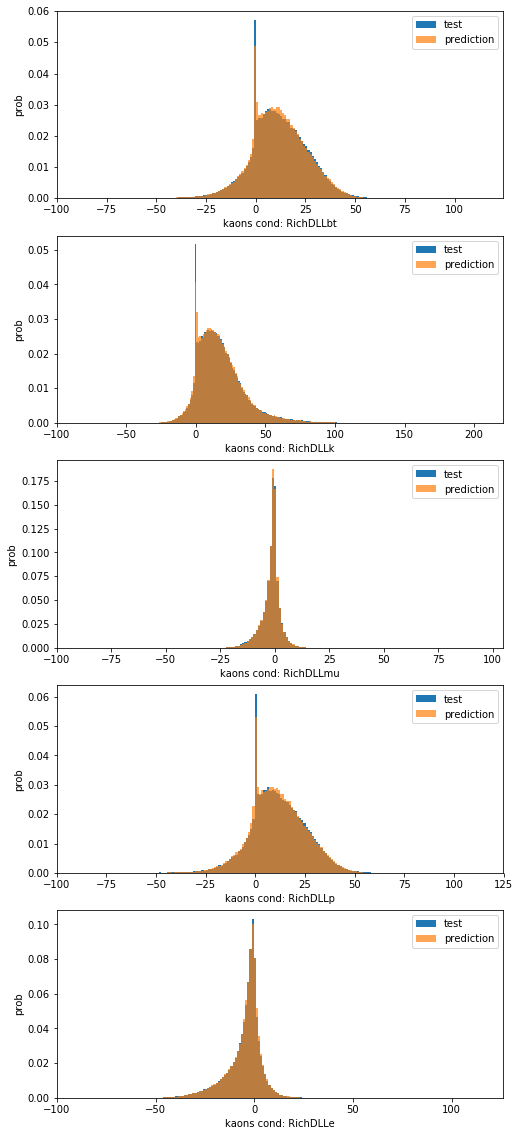

In [87]:
visualise_df([Y_test], [Y_pred_kaon_cond], 'kaons cond')

In [88]:
XY_test_back = XY_test.copy()
XY_test_back['TrackP'] *= 1000
XY_test_back['NumLongTracks'] *= 10
XY_test_back.describe()

,TrackP,TrackEta,NumLongTracks,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe
count,199999.000,199999.000,199999.000,199999.000,199999.000,199999.000,199999.000,199999.000
mean,17182.467,3.480,49.581,-3.939,1.877,-17.023,-4.351,-20.122
std,21316.204,0.773,23.169,125.009,126.139,122.667,124.948,122.513
min,1159.010,1.551,1.000,-999.000,-999.000,-999.000,-999.000,-999.000
25%,5642.670,2.872,32.000,1.500,4.739,-3.459,1.097,-8.615
50%,10442.180,3.477,46.000,10.585,14.236,-0.924,10.068,-2.714
75%,20432.104,4.087,64.000,20.805,25.480,0.288,20.328,-0.029
max,619237.625,5.727,183.000,70.944,162.853,52.266,71.288,72.590


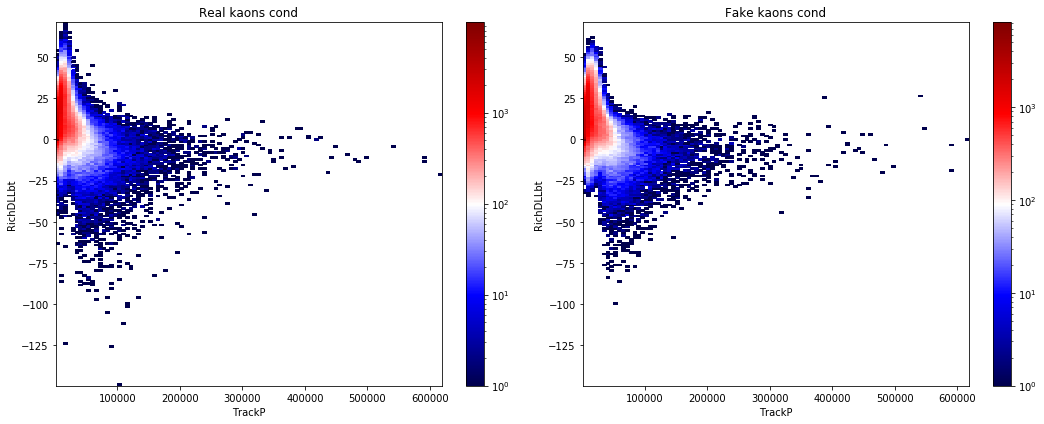

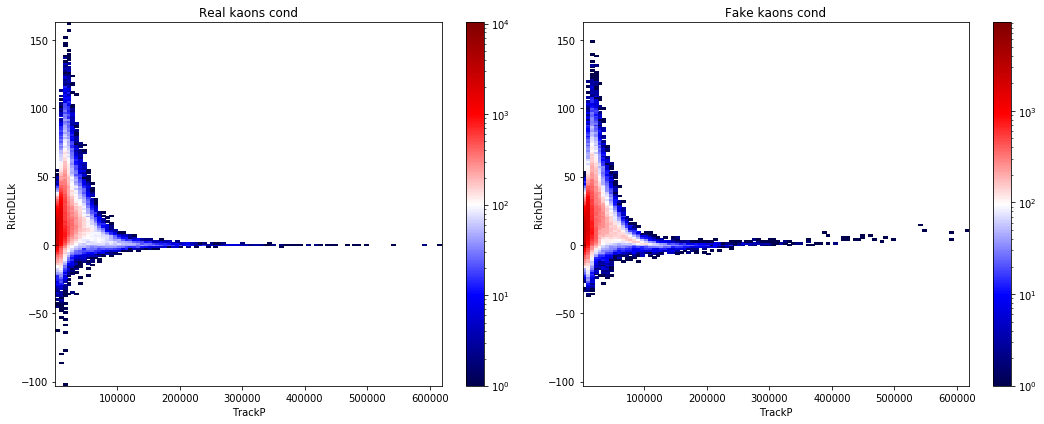

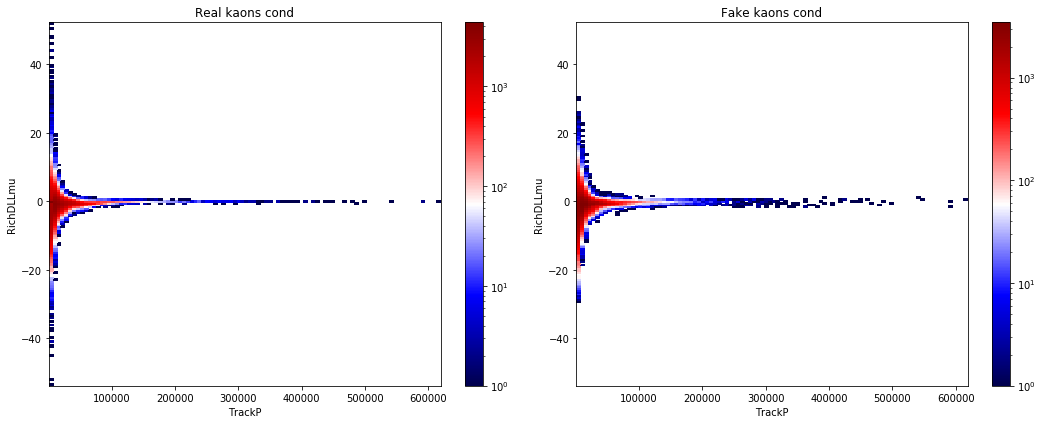

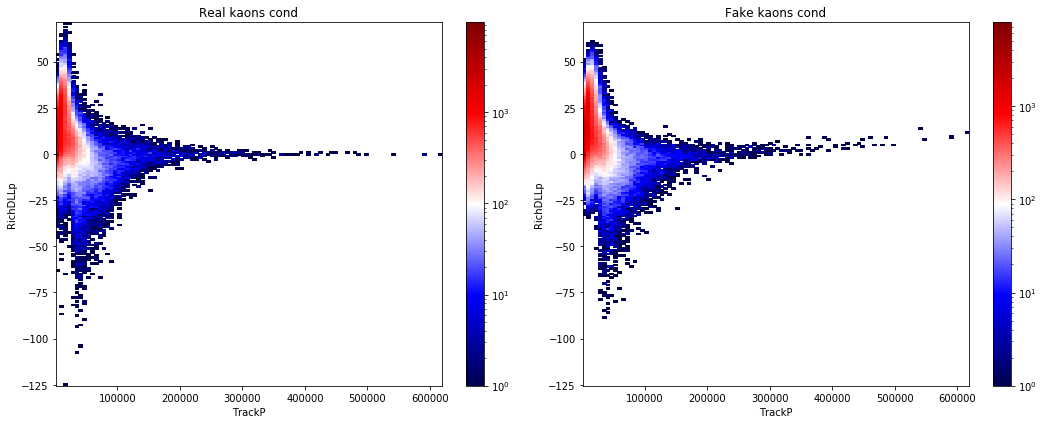

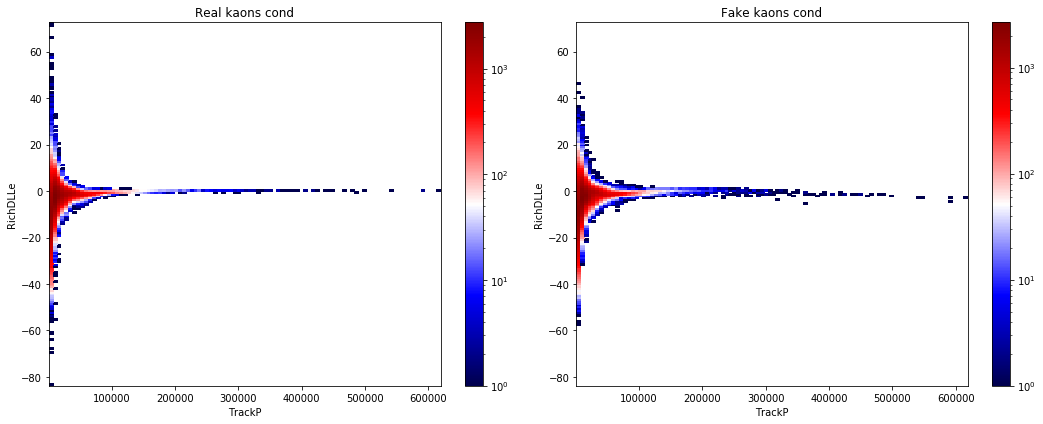

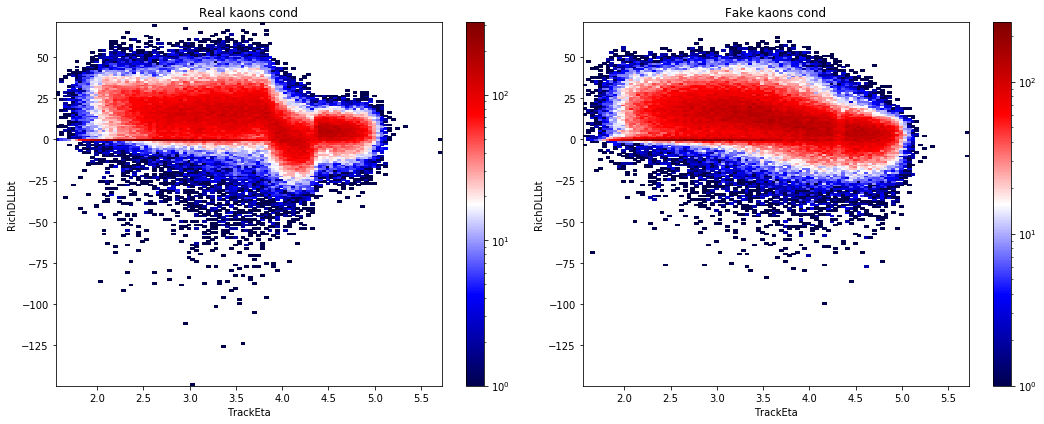

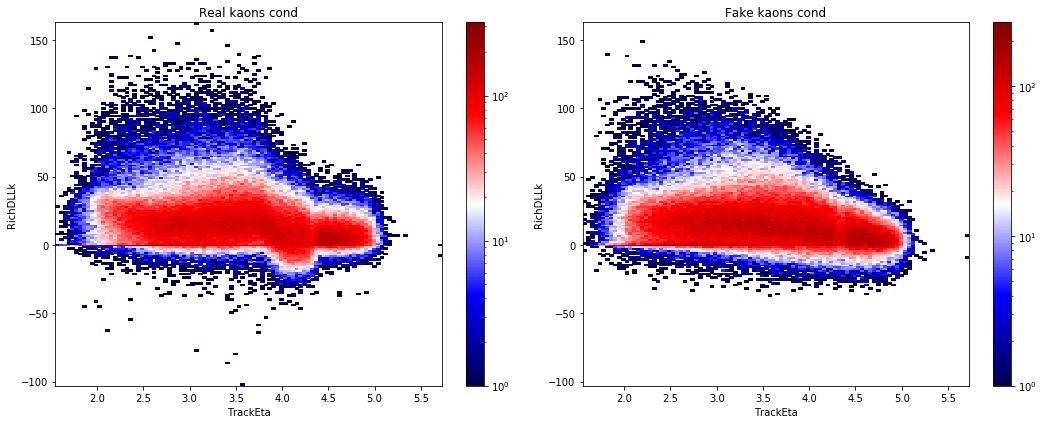

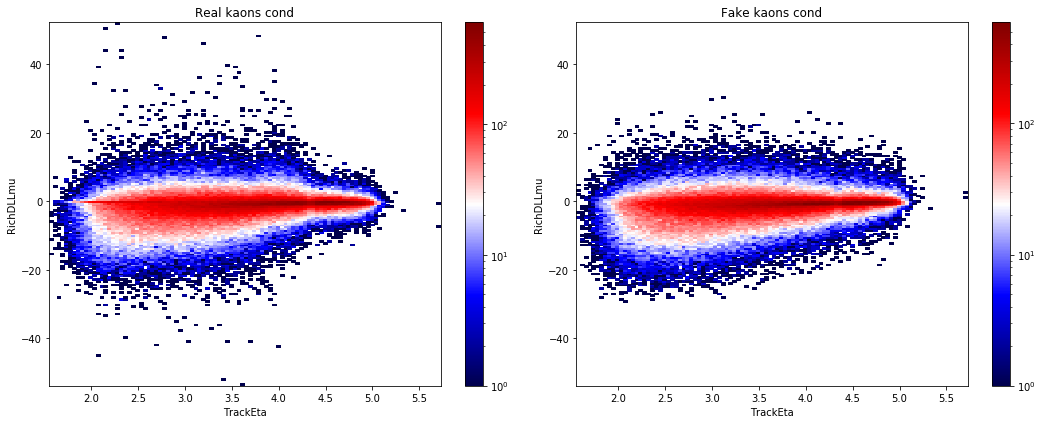

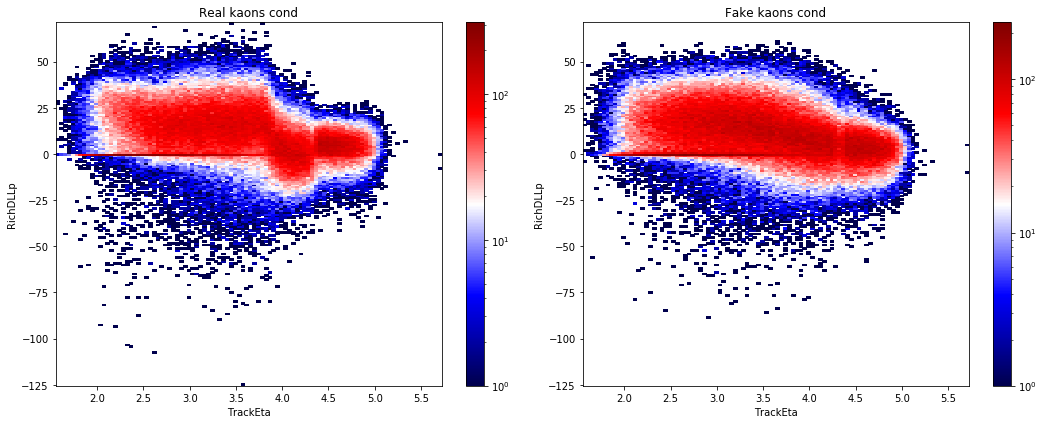

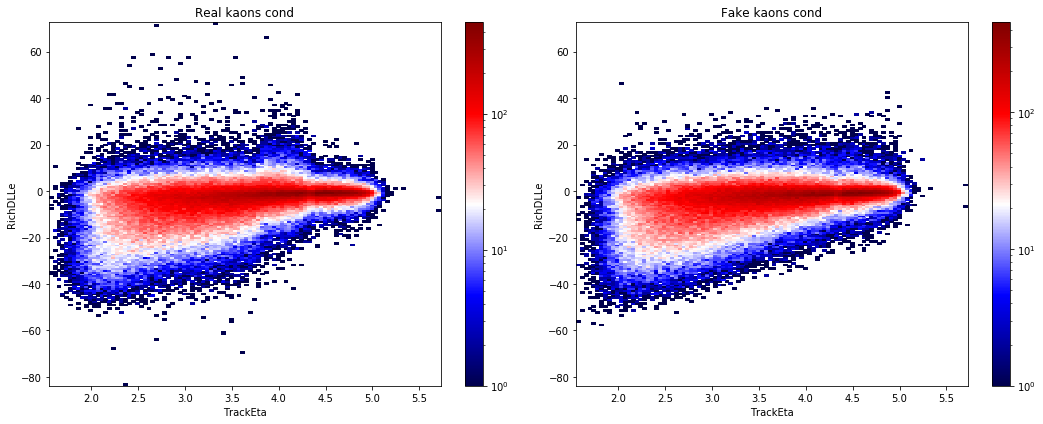

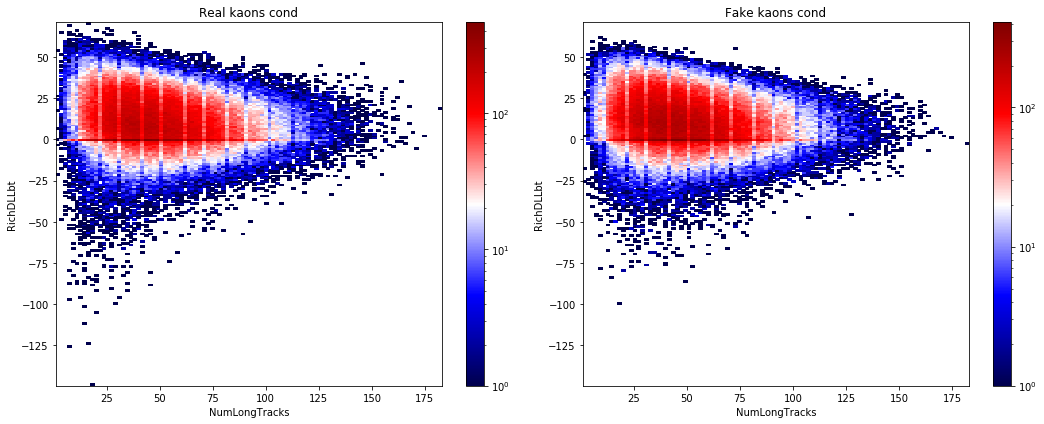

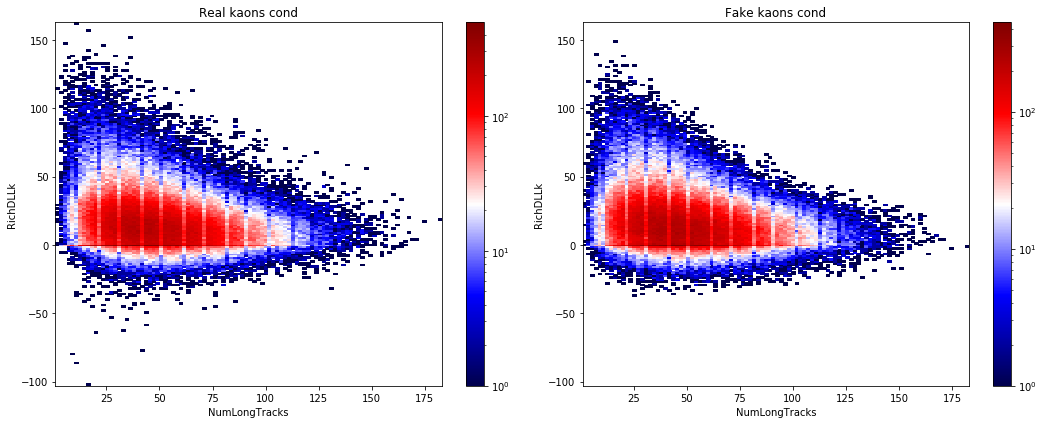

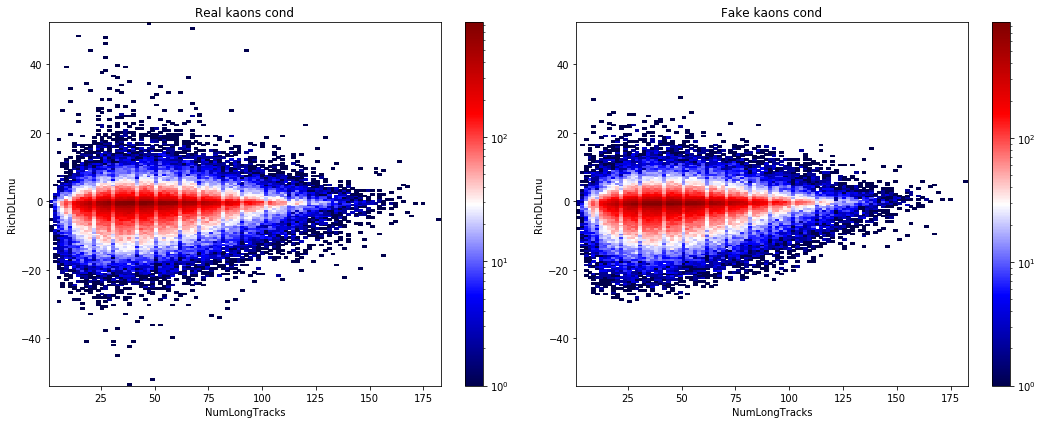

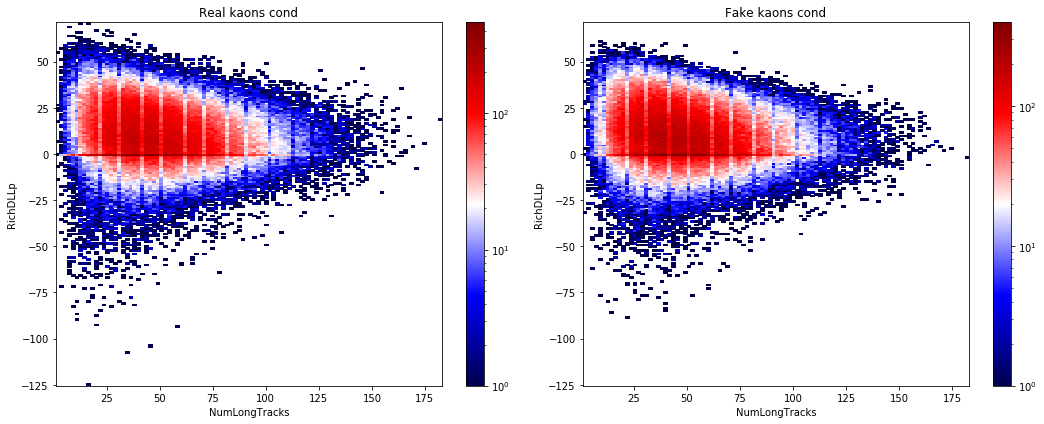

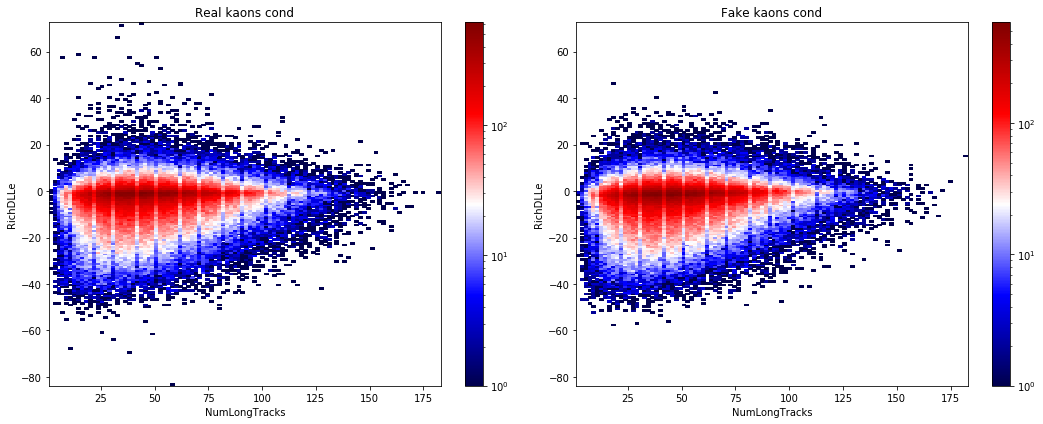

In [89]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(XY_test_back, Y_pred_kaon_cond, 'kaons cond', x_name, y_name)

#### MUONS
##### Concatenate Noise (dim=3) and X_Cols (dim=3)

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_muon)), test_size=0.2, random_state=int(time()))


In [0]:
XY_train = df_muon_scaled[all_cols].iloc[train_ids]
XY_test = df_muon_scaled[all_cols].iloc[test_ids]
X, Y = XY_train[x_cols], XY_train[y_cols]
X_test, Y_test = XY_test[x_cols], XY_test[y_cols]


X_DIMS = 3
NOISE_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

In [31]:
sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"

generator_activation = keras.activations.elu

with tf.name_scope("Generator"):
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS + NOISE_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([X_DIMS + Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    
train_batch_size = int(1e3)
real_data = get_tf_dataset(XY_train, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)

noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, NOISE_DIMS], dtype=tf.float32, name="noise")
X_fetched = get_tf_dataset(X, train_batch_size)
X_fetched = tf.dtypes.cast(X_fetched, tf.float32)
generated_data = generator(tf.concat([X_fetched, noise], axis=1))
generated_data = tf.concat([X_fetched, generated_data], axis=1)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(5e-4, tf_iter, 150, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        pred_valid = model_predict_cond(generator, X, len(X) // 20)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(XY_train), size=len(XY_train) // 20)
        print("score = %g, time %g \n" % (score_func(XY_train.iloc[random_indices], pred_valid), time() - t))
        t = time()


Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.shuffle_and_repeat(...)`.
epoch = 0, time 1.73579
predictions generated, time 1.21781
score = 0.802975, time 1.4248 

epoch = 1000, time 26.8114
predictions generated, time 0.821708
score = 0.48005, time 1.21381 

epoch = 2000, time 26.8899
predictions generated, time 0.829844
score = 0.133875, time 1.22858 

epoch = 3000, time 26.9791
predictions generated, time 0.939633
score = 0.0866, time 1.51735 

epoch = 4000, time 26.9932
predictions generated, time 0.865995
score = 0.08675, time 1.3041 

epoch = 5000, time 26.7369
predictions generated, time 0.921589
score = 0.096275, time 1.21102 

epoch = 6000, time 26.8957
predictions ge

In [0]:
noise_final = sample_noise_batch(bsize=len(X_test), NOISE_DIMS=NOISE_DIMS)
Y_pred_muon_cond = generator.predict(np.concatenate([X_test, noise_final], axis=1))

In [0]:
pred_muon_cond = np.concatenate([X_test, Y_pred_muon_cond], axis=1)
pred_muon_cond = pd.DataFrame(pred_muon_cond)
pred_muon_cond.columns = all_cols

Y_pred_muon_cond = pd.DataFrame(Y_pred_muon_cond)
Y_pred_muon_cond.columns = y_cols

In [0]:
myscore_muon_cond = score_func(XY_test, pred_muon_cond)

In [43]:
print(myscore_muon_cond)

0.023209883950580212


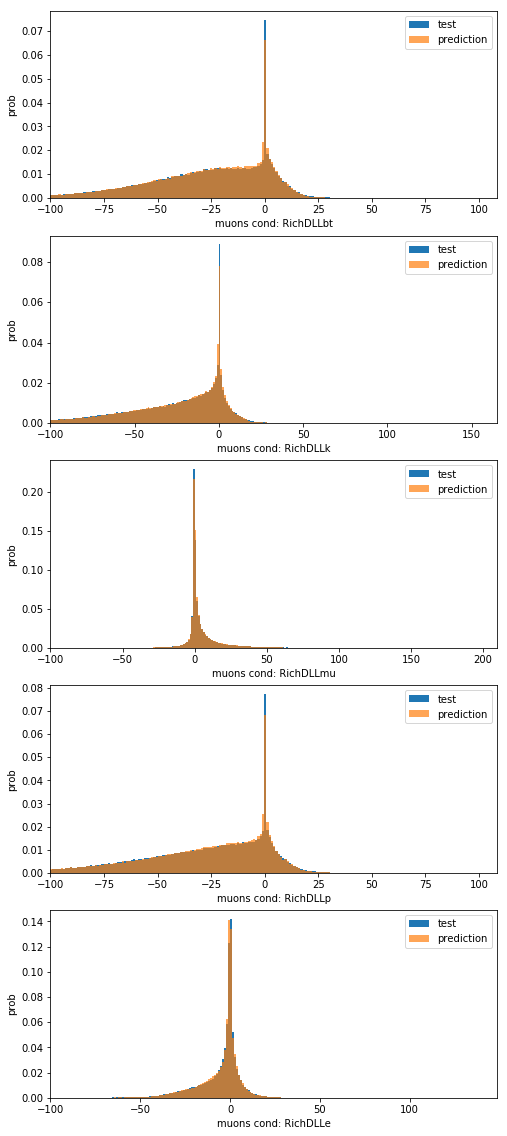

In [44]:
visualise_df([Y_test], [Y_pred_muon_cond], 'muons cond')

In [45]:
XY_test_back = XY_test.copy()
XY_test_back['TrackP'] *= 1000
XY_test_back['NumLongTracks'] *= 10
XY_test_back.describe()

,TrackP,TrackEta,NumLongTracks,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe
count,200001.000,200001.000,200001.000,200001.000,200001.000,200001.000,200001.000,200001.000
mean,30079.526,3.232,41.522,-40.111,-39.377,-8.908,-41.925,-18.979
std,45930.080,0.752,21.799,116.685,117.309,117.506,117.082,116.156
min,1153.850,1.562,1.000,-999.000,-999.000,-999.000,-999.000,-999.000
25%,6425.990,2.628,25.000,-45.658,-44.939,-0.279,-48.680,-9.563
50%,15376.280,3.184,38.000,-21.874,-17.212,0.506,-21.915,-1.105
75%,35814.301,3.794,54.000,-1.951,-0.901,5.514,-2.377,0.602
max,2928483.000,7.282,175.000,55.608,109.503,152.037,55.608,93.894


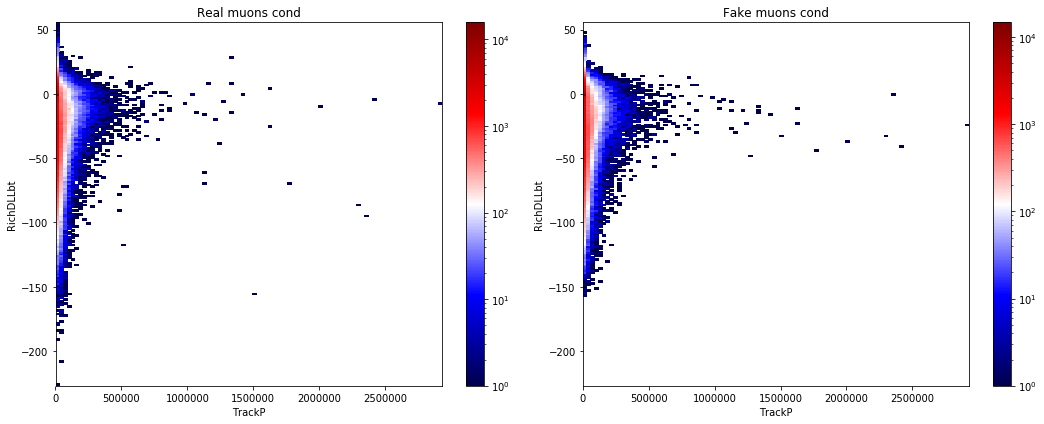

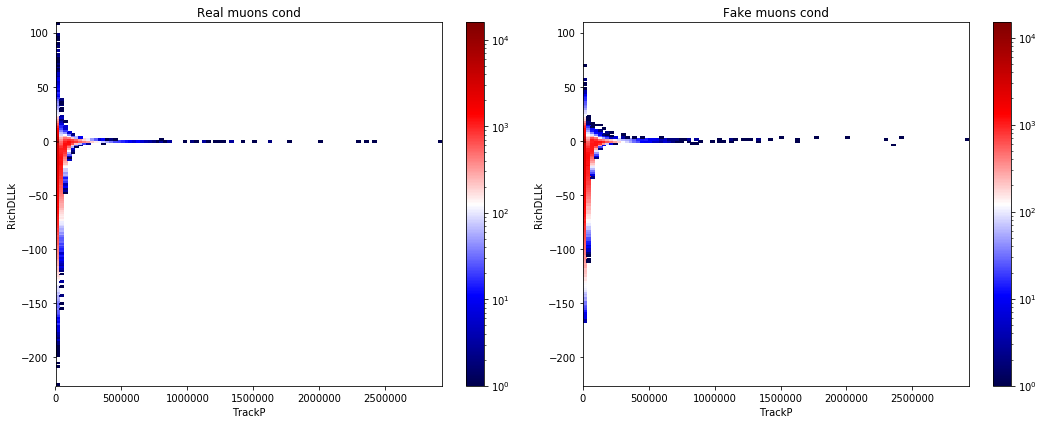

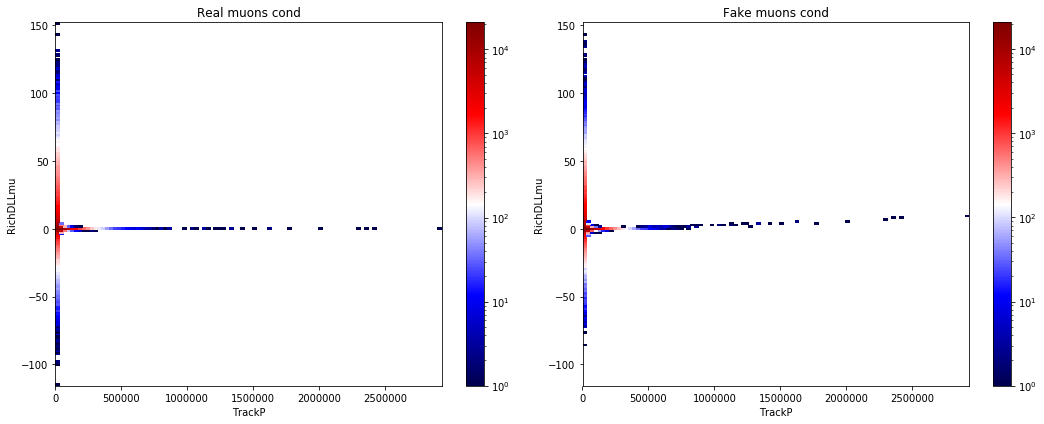

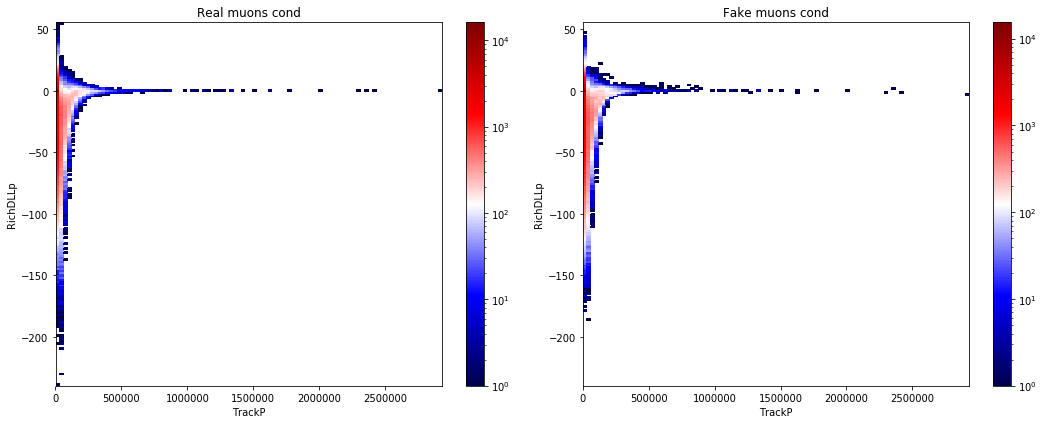

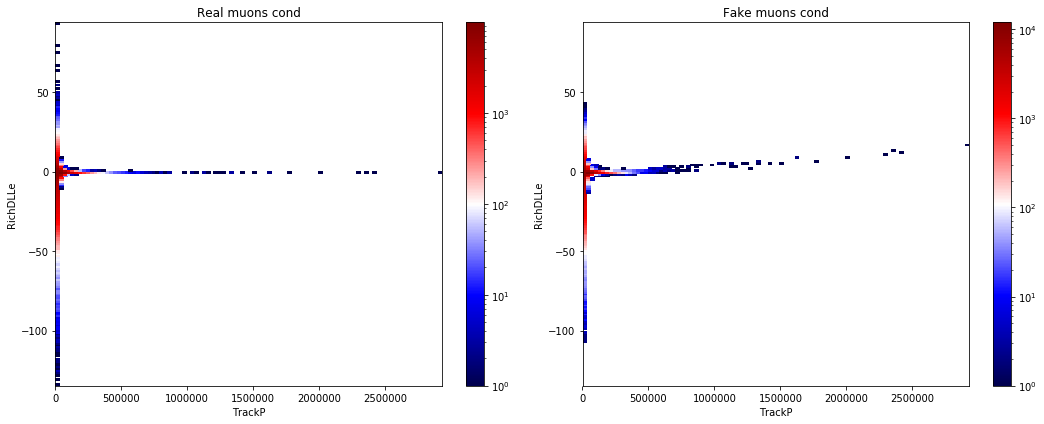

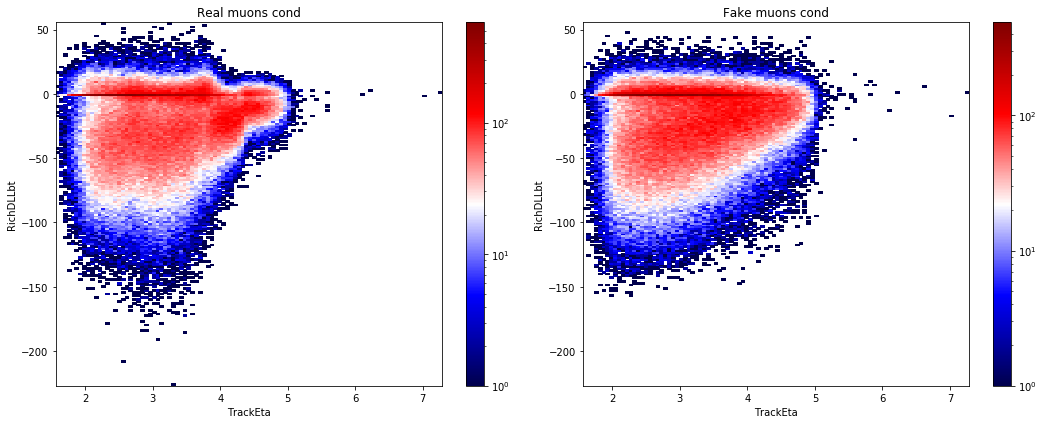

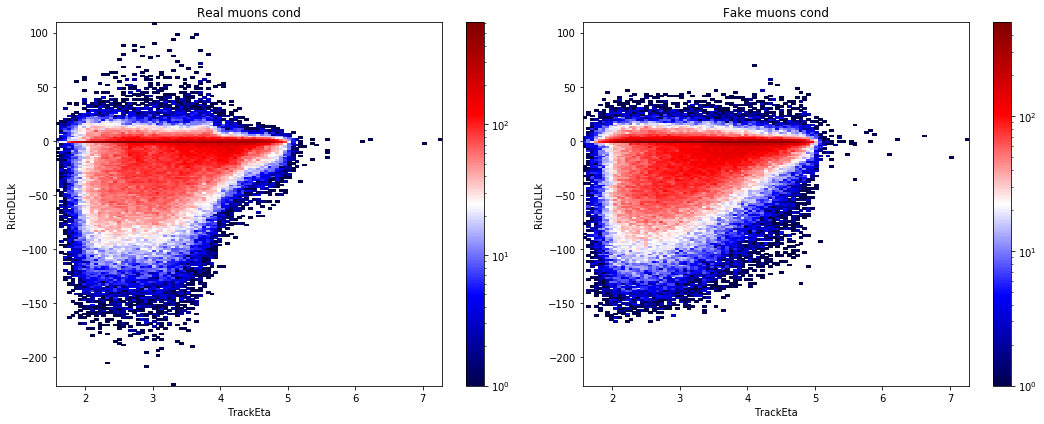

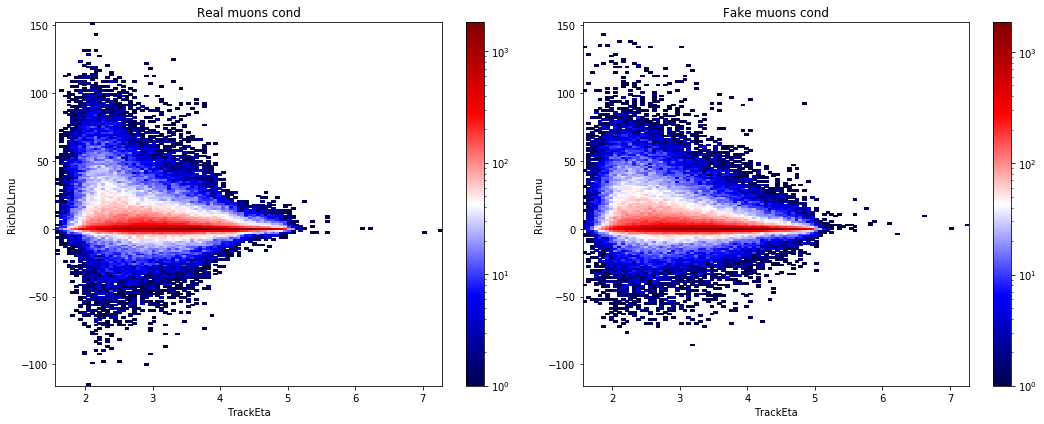

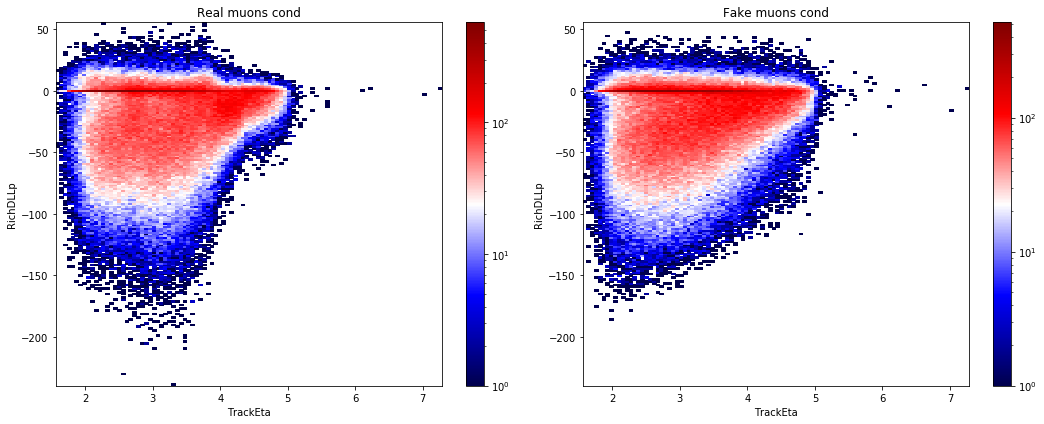

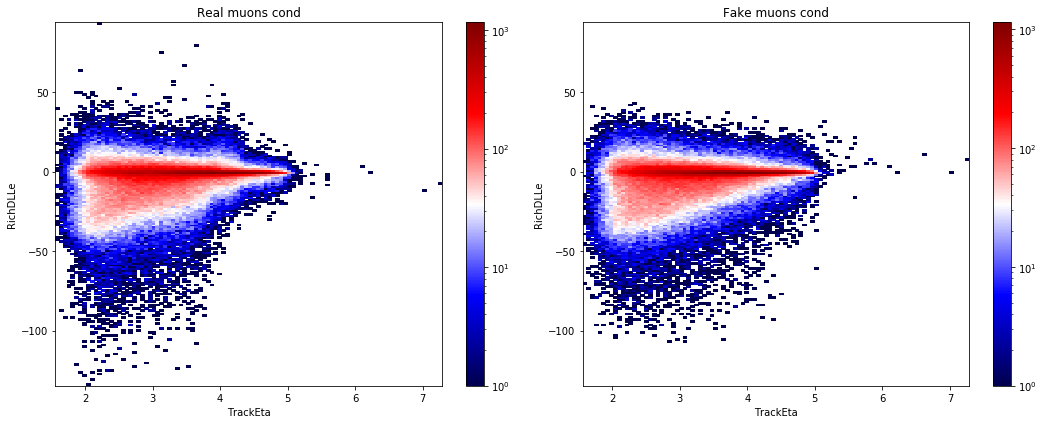

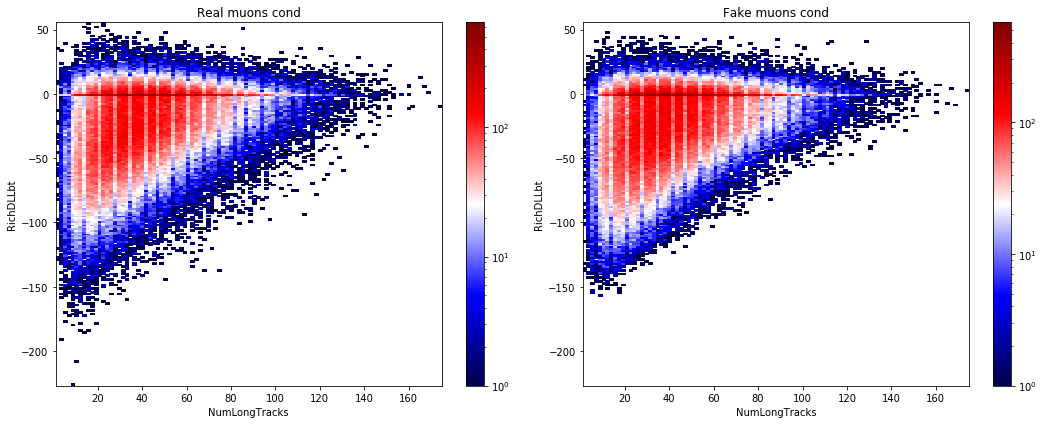

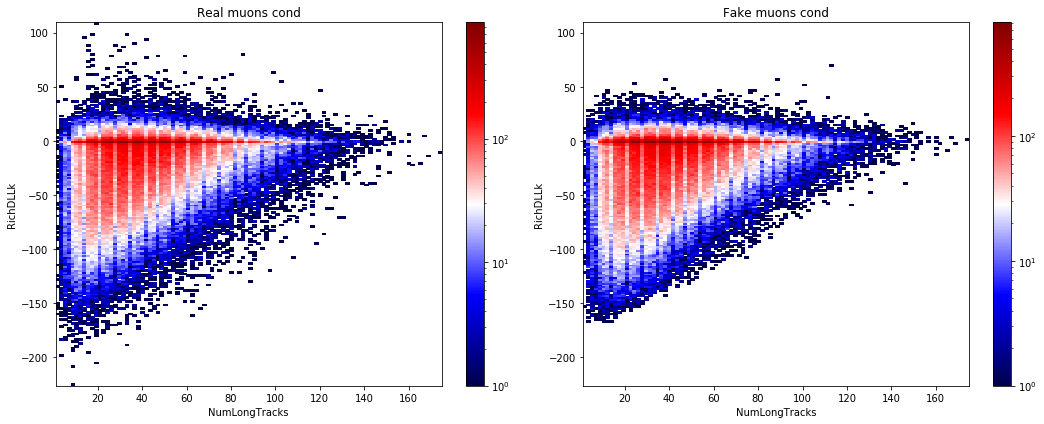

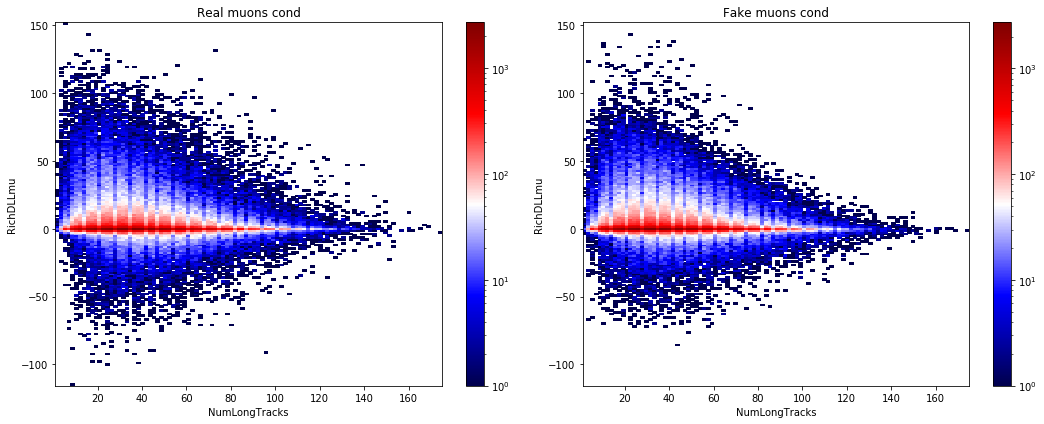

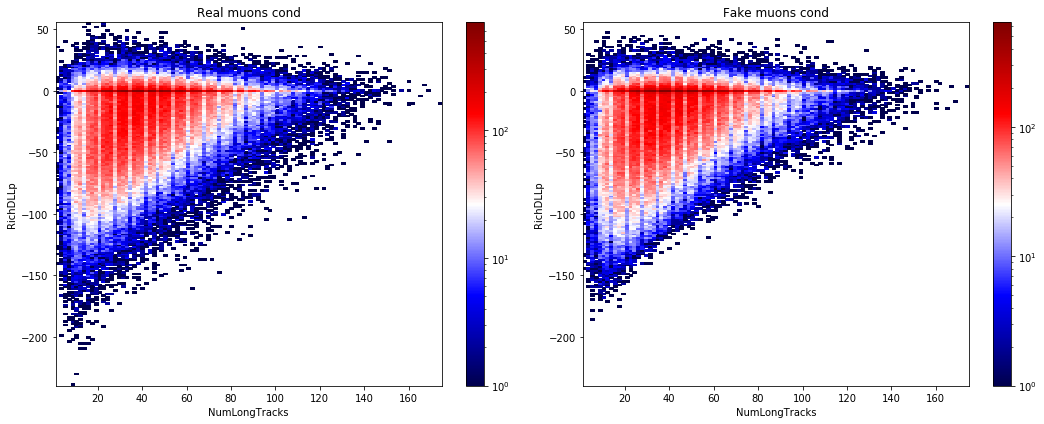

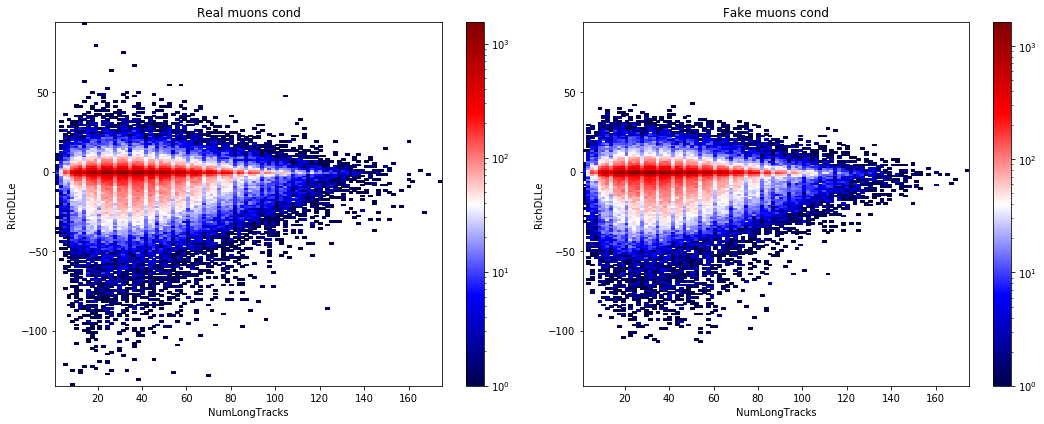

In [46]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(XY_test_back, Y_pred_muon_cond, 'muons cond', x_name, y_name)

#### PIONS
##### Concatenate Noise (dim=3) and X_Cols (dim=3)

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_pion)), test_size=0.2, random_state=int(time()))


In [0]:
XY_train = df_pion_scaled[all_cols].iloc[train_ids]
XY_test = df_pion_scaled[all_cols].iloc[test_ids]
X, Y = XY_train[x_cols], XY_train[y_cols]
X_test, Y_test = XY_test[x_cols], XY_test[y_cols]


X_DIMS = 3
NOISE_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

In [93]:
sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"

generator_activation = keras.activations.elu

with tf.name_scope("Generator"):
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS + NOISE_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([X_DIMS + Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    
train_batch_size = int(1e3)
real_data = get_tf_dataset(XY_train, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)

noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, NOISE_DIMS], dtype=tf.float32, name="noise")
X_fetched = get_tf_dataset(X, train_batch_size)
X_fetched = tf.dtypes.cast(X_fetched, tf.float32)
generated_data = generator(tf.concat([X_fetched, noise], axis=1))
generated_data = tf.concat([X_fetched, generated_data], axis=1)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(5e-4, tf_iter, 150, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        pred_valid = model_predict_cond(generator, X, len(X) // 20)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(XY_train), size=len(XY_train) // 20)
        print("score = %g, time %g \n" % (score_func(XY_train.iloc[random_indices], pred_valid), time() - t))
        t = time()


epoch = 0, time 1.92734
predictions generated, time 2.90097
score = 0.840175, time 1.17571 

epoch = 1000, time 27.6465
predictions generated, time 1.112
score = 0.291575, time 1.2434 

epoch = 2000, time 27.4852
predictions generated, time 1.10781
score = 0.12595, time 1.22447 

epoch = 3000, time 27.7342
predictions generated, time 1.07885
score = 0.094775, time 1.22106 

epoch = 4000, time 27.6754
predictions generated, time 1.076
score = 0.148, time 1.22634 

epoch = 5000, time 27.6184
predictions generated, time 1.09535
score = 0.082175, time 1.22981 

epoch = 6000, time 27.8238
predictions generated, time 1.10333
score = 0.1721, time 1.228 

epoch = 7000, time 27.7981
predictions generated, time 1.09561
score = 0.061975, time 1.22097 

epoch = 8000, time 27.5481
predictions generated, time 1.07884
score = 0.075875, time 1.2152 

epoch = 9000, time 27.641
predictions generated, time 1.12909
score = 0.0629, time 1.24141 

epoch = 10000, time 27.473
predictions generated, time 1.108

In [0]:
noise_final = sample_noise_batch(bsize=len(X_test), NOISE_DIMS=NOISE_DIMS)
Y_pred_pion_cond = generator.predict(np.concatenate([X_test, noise_final], axis=1))

In [0]:
pred_pion_cond = np.concatenate([X_test, Y_pred_pion_cond], axis=1)
pred_pion_cond = pd.DataFrame(pred_pion_cond)
pred_pion_cond.columns = all_cols

Y_pred_pion_cond = pd.DataFrame(Y_pred_pion_cond)
Y_pred_pion_cond.columns = y_cols

In [0]:
myscore_pion_cond = score_func(XY_test, pred_pion_cond)

In [97]:
print(myscore_pion_cond)

0.03201967980320197


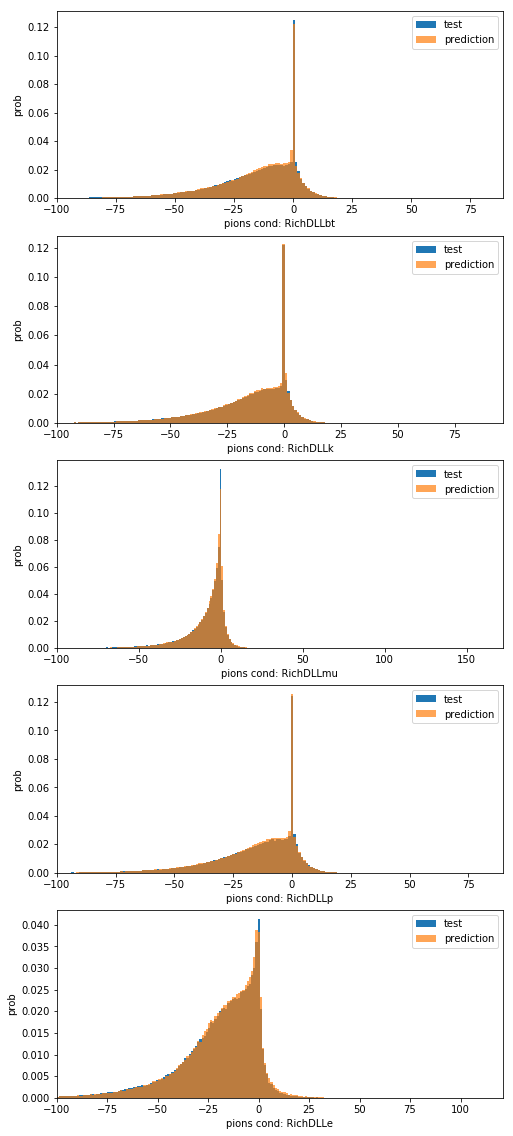

In [98]:
visualise_df([Y_test], [Y_pred_pion_cond], 'pions cond')

In [99]:
XY_test_back = XY_test.copy()
XY_test_back['TrackP'] *= 1000
XY_test_back['NumLongTracks'] *= 10
XY_test_back.describe()

,TrackP,TrackEta,NumLongTracks,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe
count,200002.000,200002.000,200002.000,200002.000,200002.000,200002.000,200002.000,200002.000
mean,11681.448,3.510,50.056,-41.013,-41.786,-34.093,-41.230,-45.095
std,15543.976,0.761,22.989,157.688,157.687,158.247,157.687,157.196
min,1121.480,1.547,1.000,-999.000,-999.000,-999.000,-999.000,-999.000
25%,3935.690,2.923,33.000,-26.183,-26.875,-13.176,-26.326,-30.400
50%,6963.635,3.508,47.000,-11.317,-11.553,-4.296,-11.410,-15.730
75%,13428.250,4.100,64.000,-0.561,-0.857,-0.349,-0.638,-5.080
max,883809.312,8.133,182.000,37.104,44.050,116.407,37.916,67.753


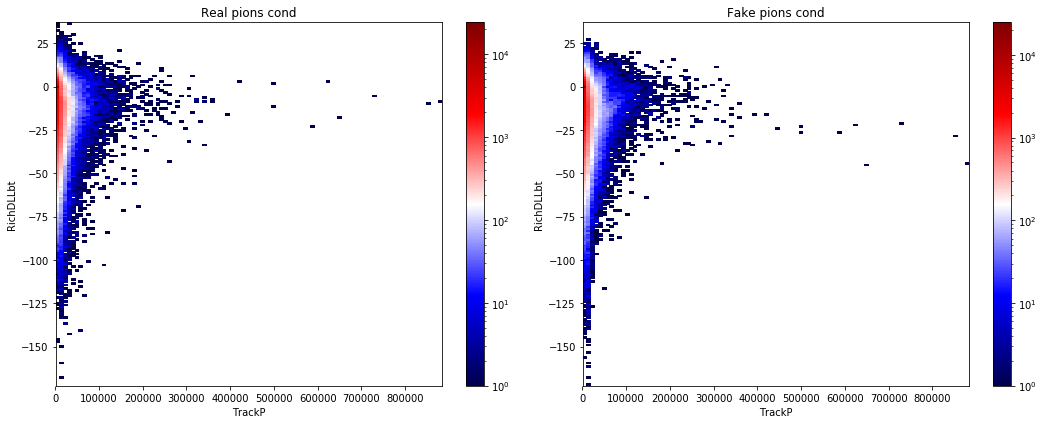

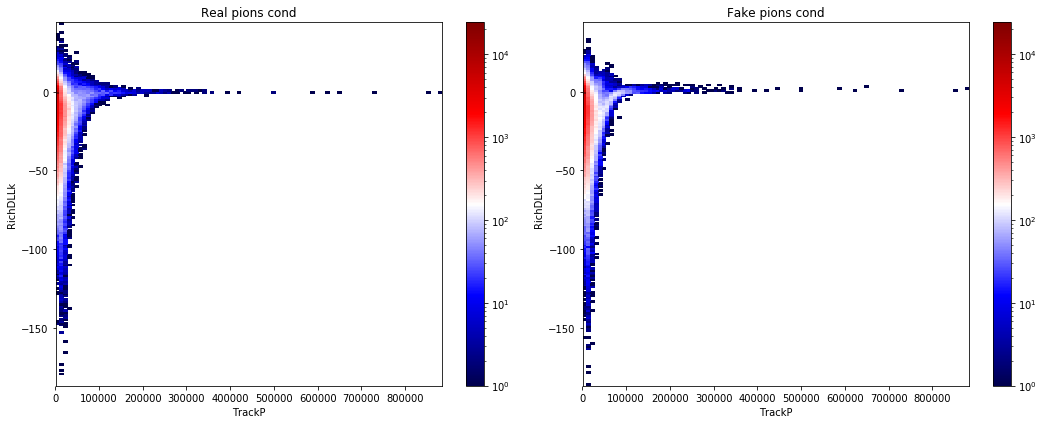

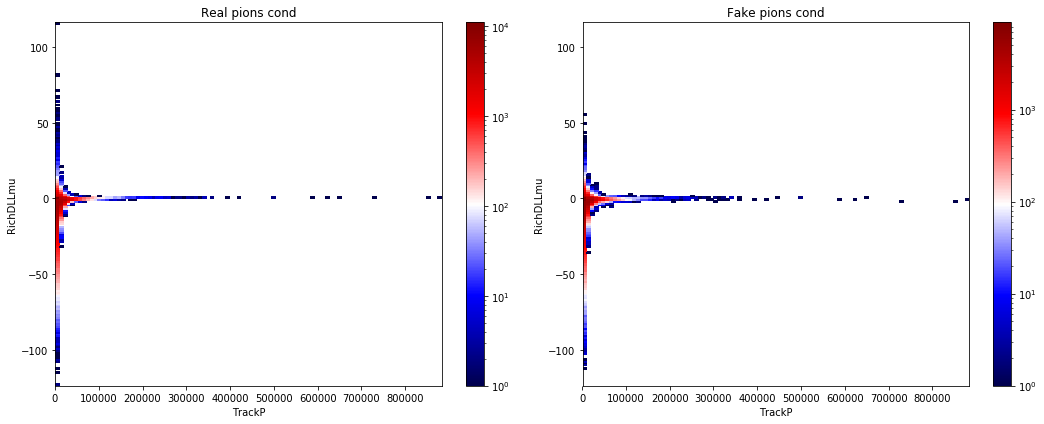

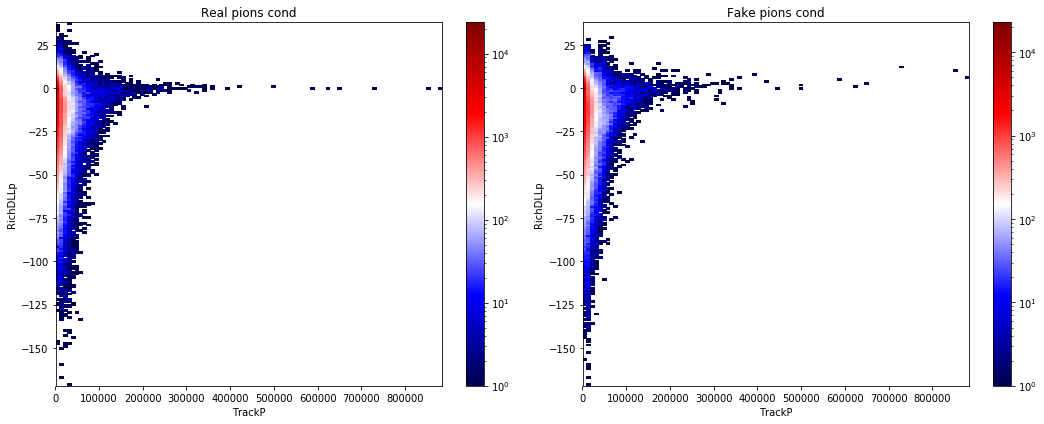

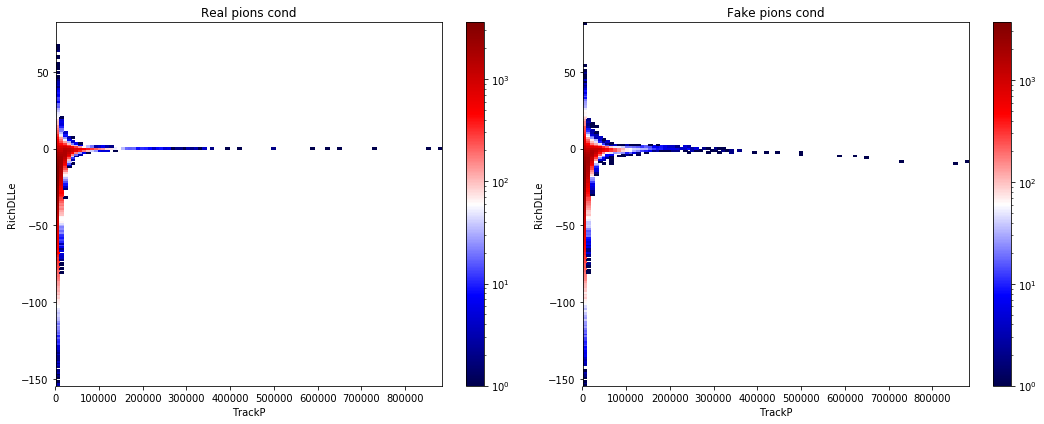

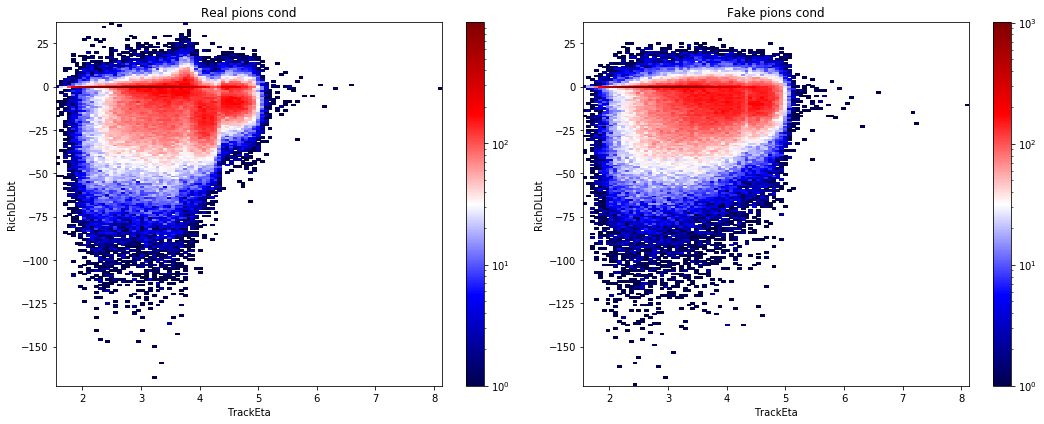

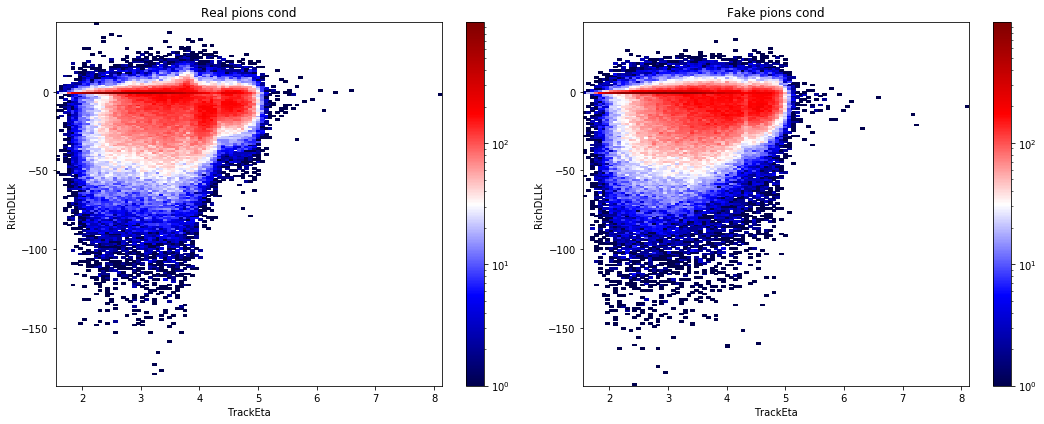

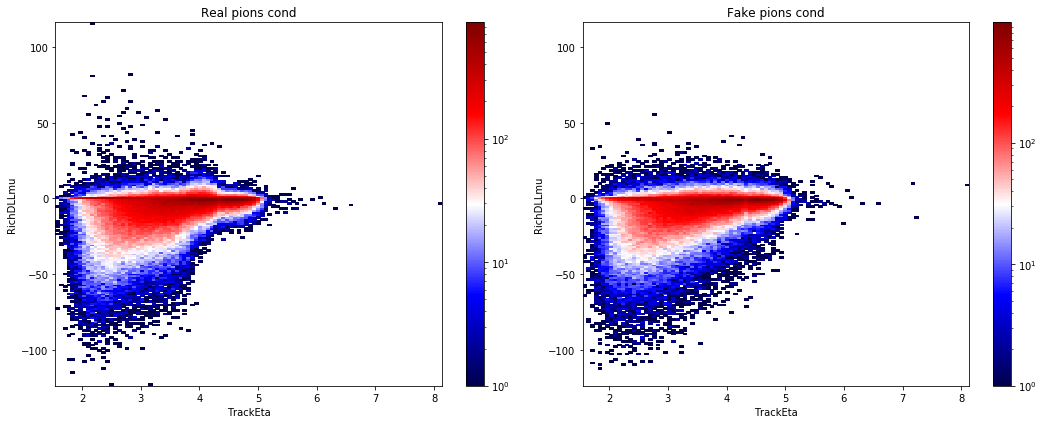

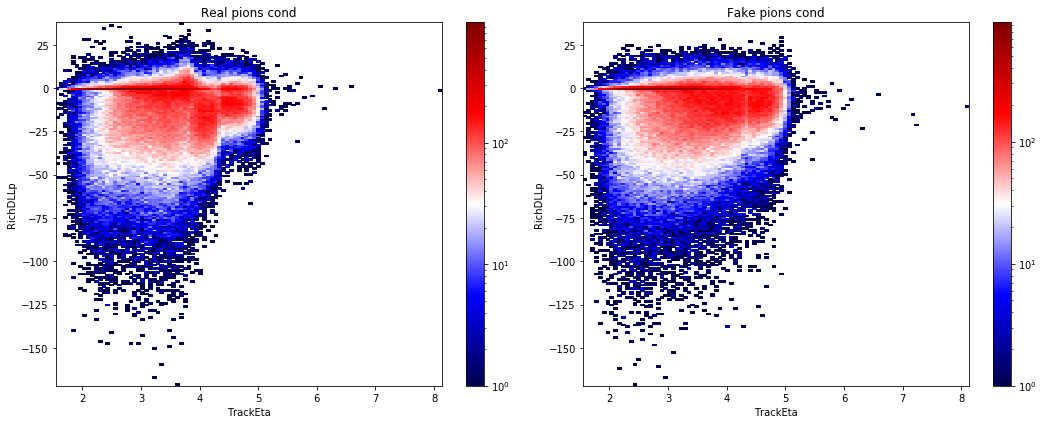

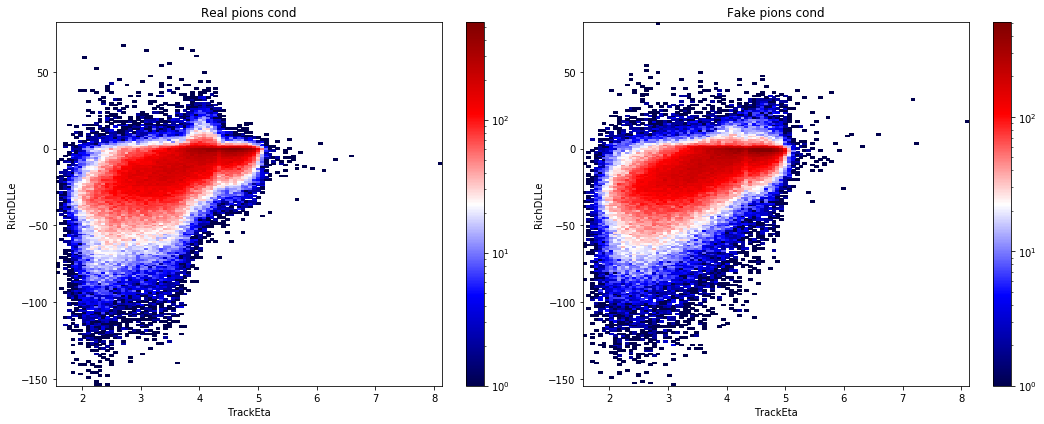

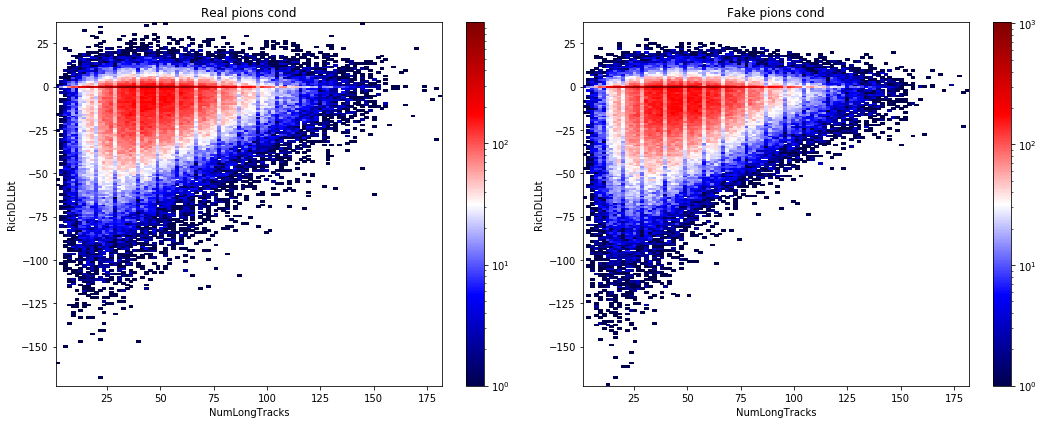

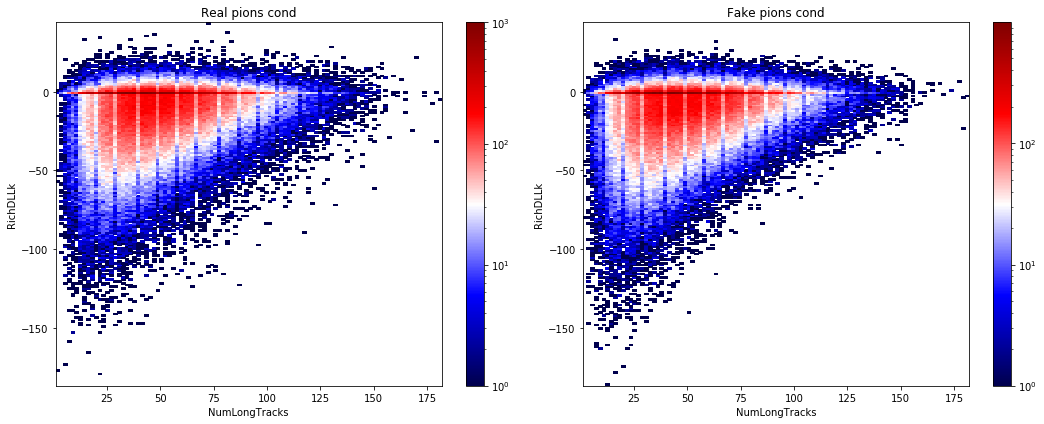

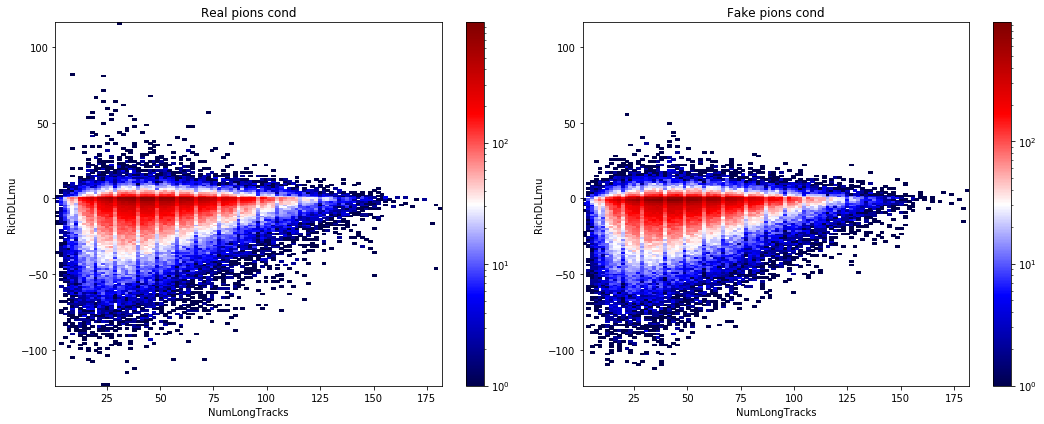

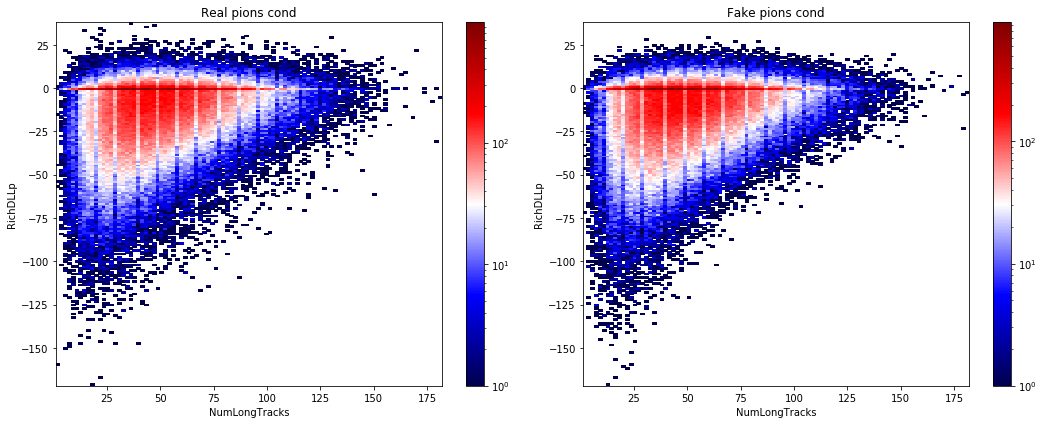

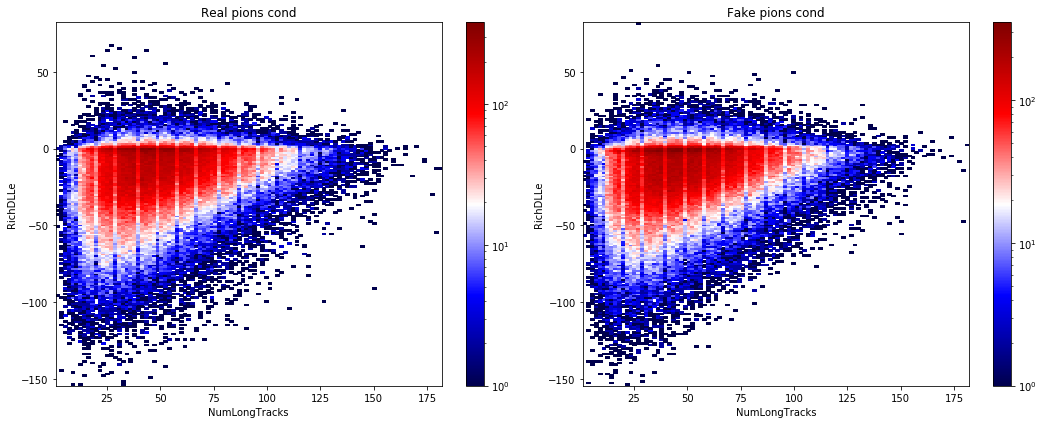

In [100]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(XY_test_back, Y_pred_pion_cond, 'pions cond', x_name, y_name)

#### PROTONS
##### Concatenate Noise (dim=3) and X_Cols (dim=3)

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_proton)), test_size=0.2, random_state=int(time()))


In [0]:
XY_train = df_proton_scaled[all_cols].iloc[train_ids]
XY_test = df_proton_scaled[all_cols].iloc[test_ids]
X, Y = XY_train[x_cols], XY_train[y_cols]
X_test, Y_test = XY_test[x_cols], XY_test[y_cols]


X_DIMS = 3
NOISE_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

In [63]:
sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"

generator_activation = keras.activations.elu

with tf.name_scope("Generator"):
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS + NOISE_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([X_DIMS + Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    
train_batch_size = int(1e3)
real_data = get_tf_dataset(XY_train, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)

noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, NOISE_DIMS], dtype=tf.float32, name="noise")
X_fetched = get_tf_dataset(X, train_batch_size)
X_fetched = tf.dtypes.cast(X_fetched, tf.float32)
generated_data = generator(tf.concat([X_fetched, noise], axis=1))
generated_data = tf.concat([X_fetched, generated_data], axis=1)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(5e-4, tf_iter, 150, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        pred_valid = model_predict_cond(generator, X, len(X) // 20)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(XY_train), size=len(XY_train) // 20)
        print("score = %g, time %g \n" % (score_func(XY_train.iloc[random_indices], pred_valid), time() - t))
        t = time()


epoch = 0, time 1.53826
predictions generated, time 2.16944
score = 0.894597, time 1.19412 

epoch = 1000, time 27.5039
predictions generated, time 0.97207
score = 0.315783, time 1.24995 

epoch = 2000, time 27.4434
predictions generated, time 0.953981
score = 0.142879, time 1.24228 

epoch = 3000, time 27.4469
predictions generated, time 0.986129
score = 0.150404, time 1.22089 

epoch = 4000, time 27.3335
predictions generated, time 0.959742
score = 0.133128, time 1.21562 

epoch = 5000, time 27.4419
predictions generated, time 0.979715
score = 0.0733018, time 1.25396 

epoch = 6000, time 27.317
predictions generated, time 1.01949
score = 0.110028, time 1.22252 

epoch = 7000, time 27.3403
predictions generated, time 0.953048
score = 0.109503, time 1.23103 

epoch = 8000, time 27.448
predictions generated, time 0.990824
score = 0.0538513, time 1.23299 

epoch = 9000, time 27.6452
predictions generated, time 0.975618
score = 0.0620016, time 1.21664 

epoch = 10000, time 27.3644
predict

In [0]:
noise_final = sample_noise_batch(bsize=len(X_test), NOISE_DIMS=NOISE_DIMS)
Y_pred_proton_cond = generator.predict(np.concatenate([X_test, noise_final], axis=1))

In [0]:
pred_proton_cond = np.concatenate([X_test, Y_pred_proton_cond], axis=1)
pred_proton_cond = pd.DataFrame(pred_proton_cond)
pred_proton_cond.columns = all_cols

Y_pred_proton_cond = pd.DataFrame(Y_pred_proton_cond)
Y_pred_proton_cond.columns = y_cols

In [0]:
myscore_proton_cond = score_func(XY_test, pred_proton_cond)

In [67]:
print(myscore_proton_cond)

0.0234151170755853


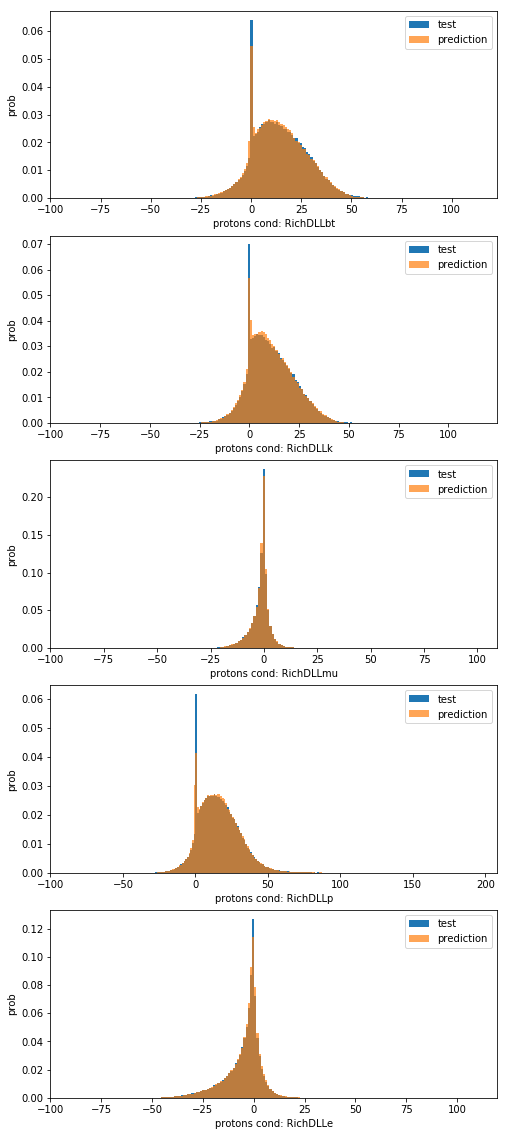

In [68]:
visualise_df([Y_test], [Y_pred_proton_cond], 'protons cond')

In [69]:
XY_test_back = XY_test.copy()
XY_test_back['TrackP'] *= 1000
XY_test_back['NumLongTracks'] *= 10
XY_test_back.describe()

,TrackP,TrackEta,NumLongTracks,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe
count,199999.000,199999.000,199999.000,199999.000,199999.000,199999.000,199999.000,199999.000
mean,17652.164,3.425,50.586,-0.504,-3.854,-16.042,1.449,-19.211
std,22222.613,0.778,22.955,121.453,120.838,118.917,121.830,118.793
min,1175.710,1.541,1.000,-999.000,-999.000,-999.000,-999.000,-999.000
25%,5506.325,2.804,34.000,3.520,1.743,-3.384,4.805,-8.820
50%,10440.500,3.418,48.000,12.837,9.110,-0.708,14.380,-2.321
75%,21137.211,4.031,65.000,23.197,18.087,0.346,24.802,0.175
max,909573.688,5.927,186.000,69.065,70.819,56.301,150.505,66.297


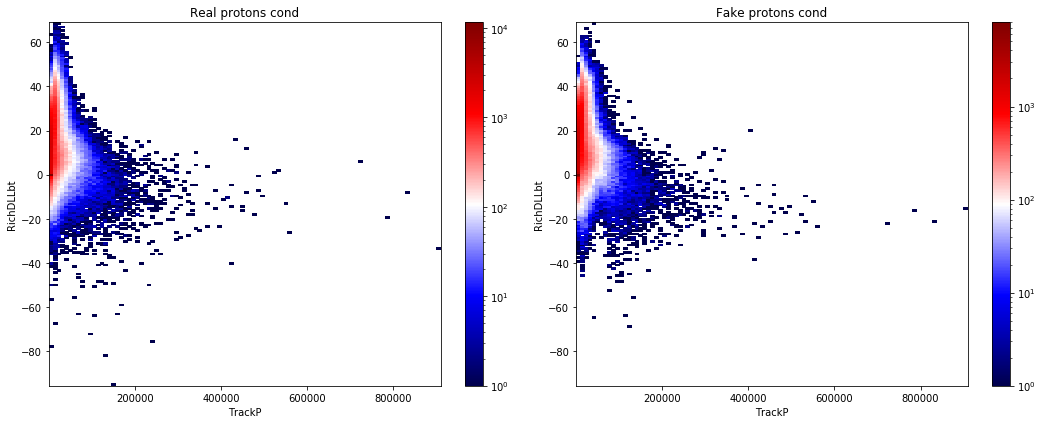

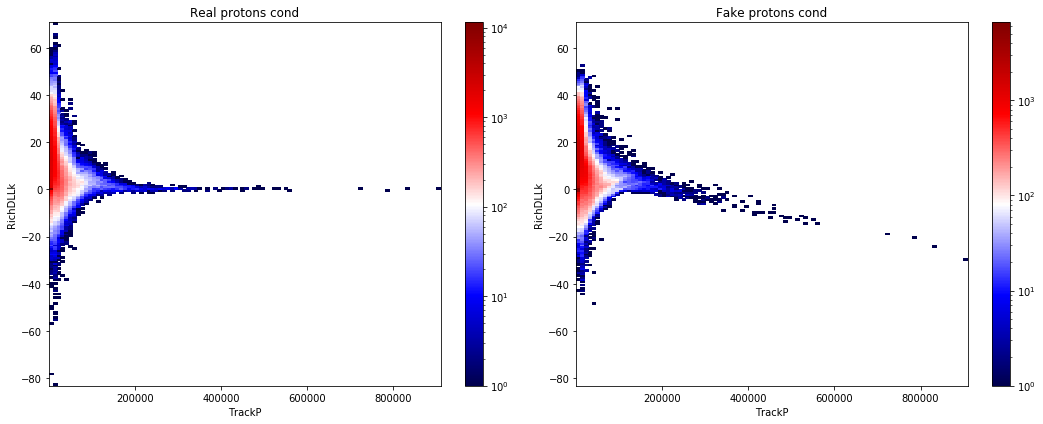

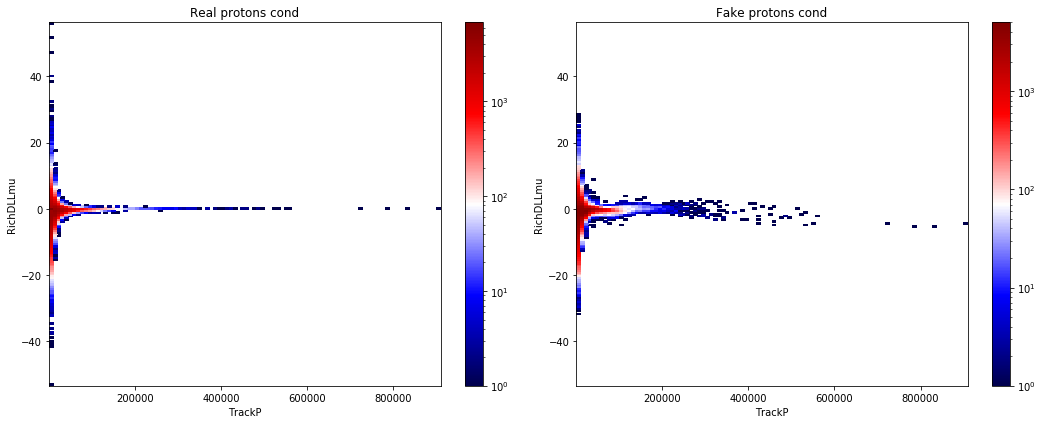

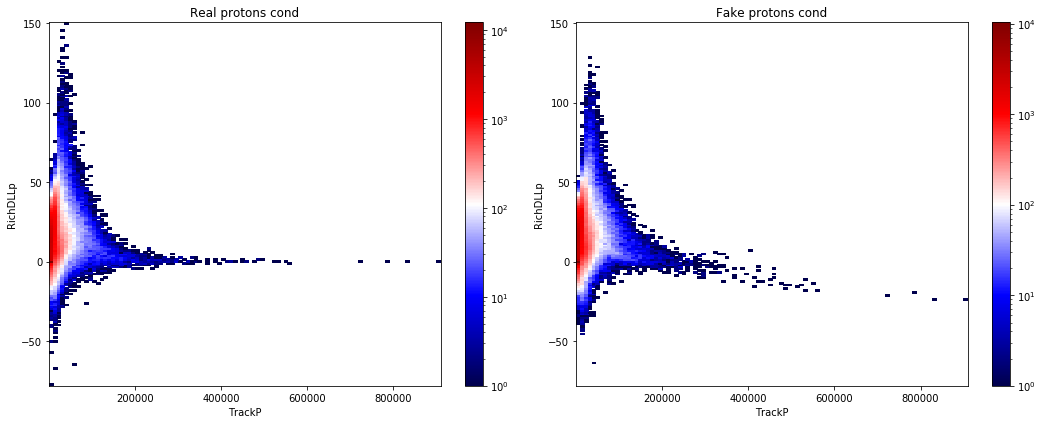

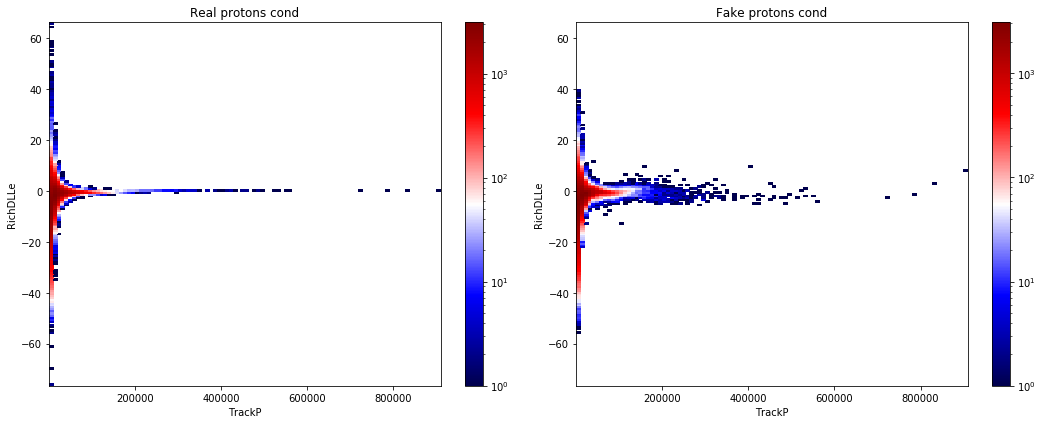

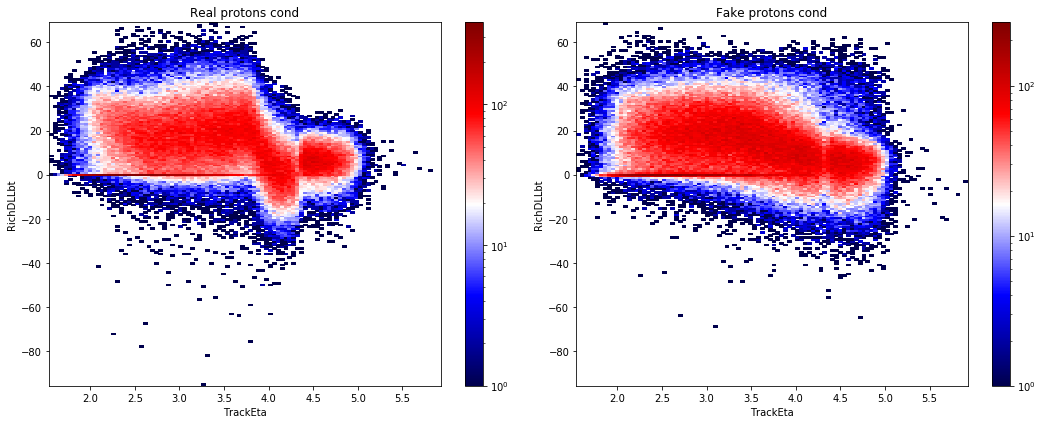

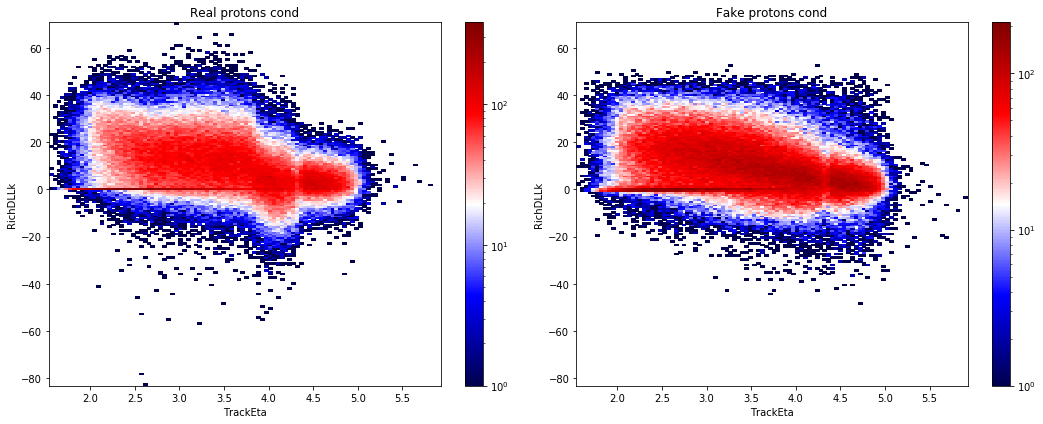

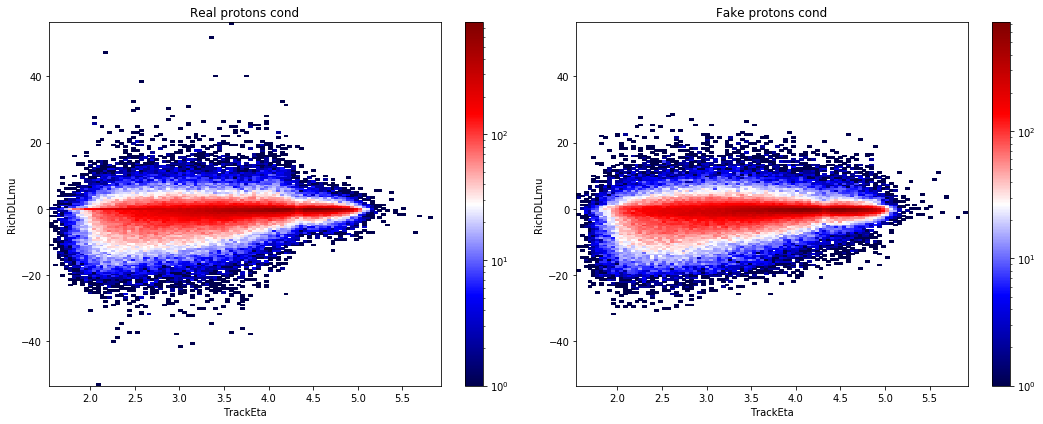

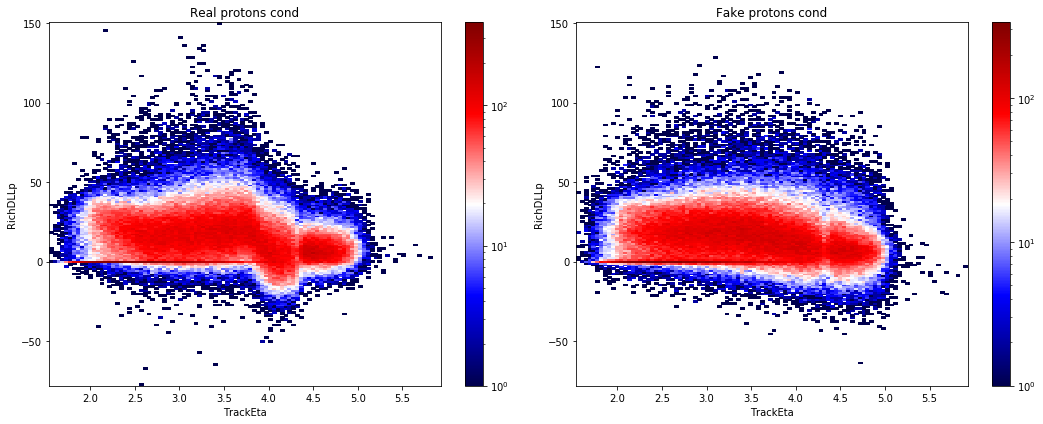

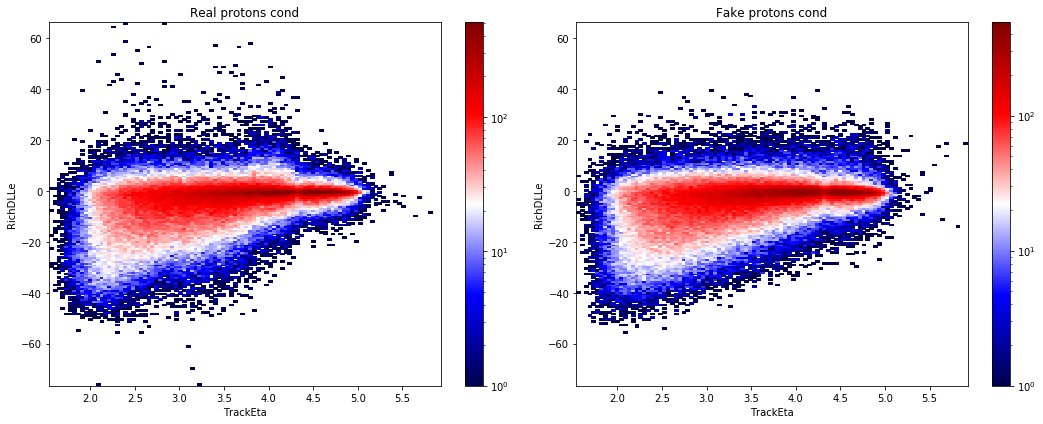

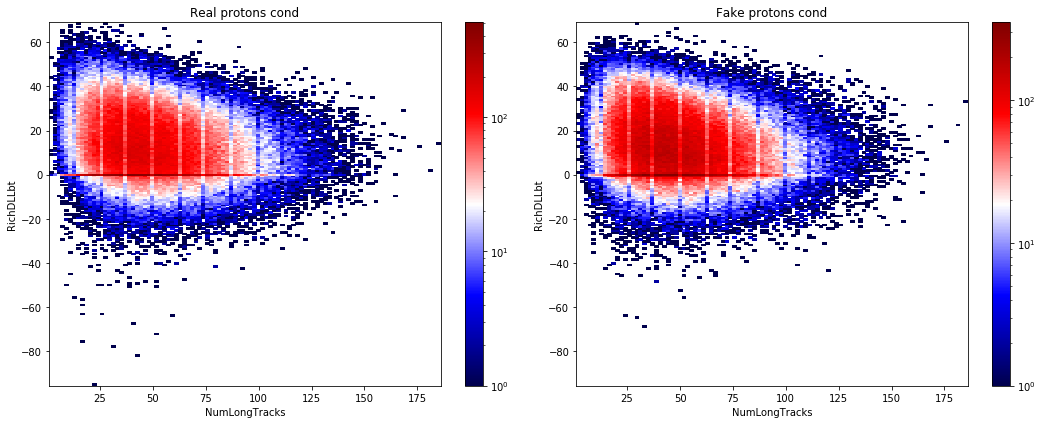

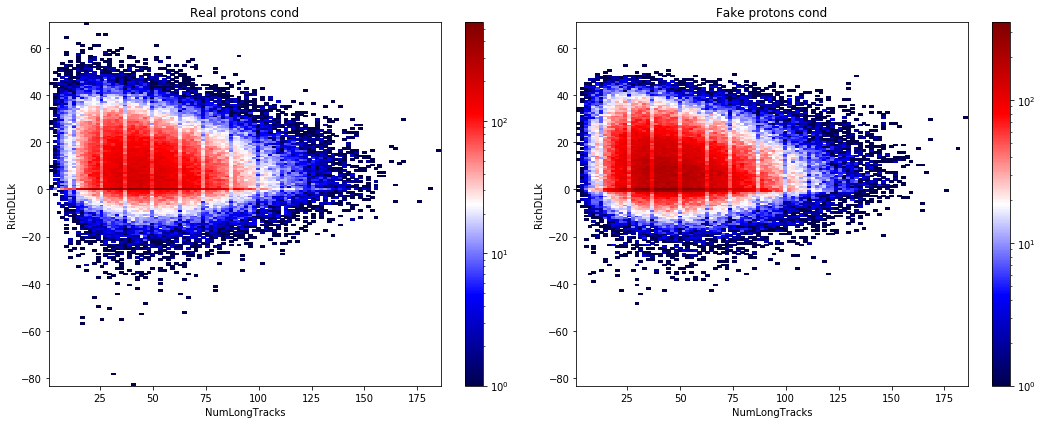

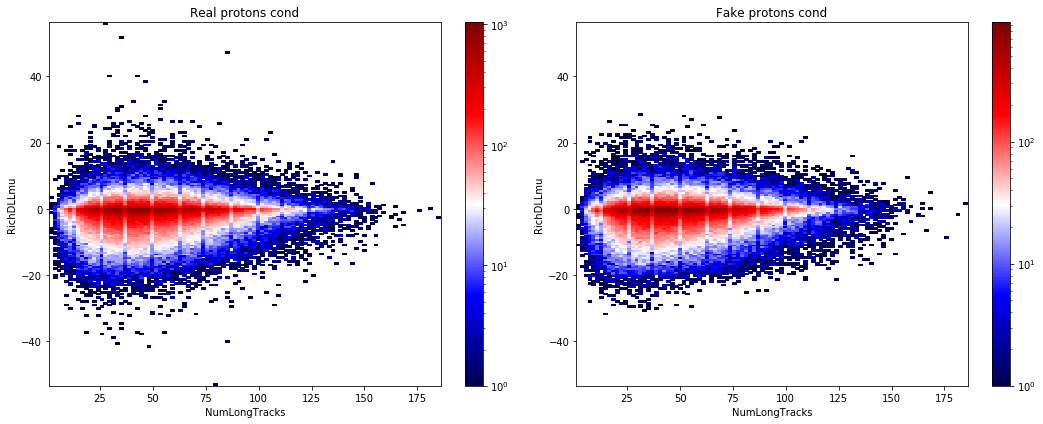

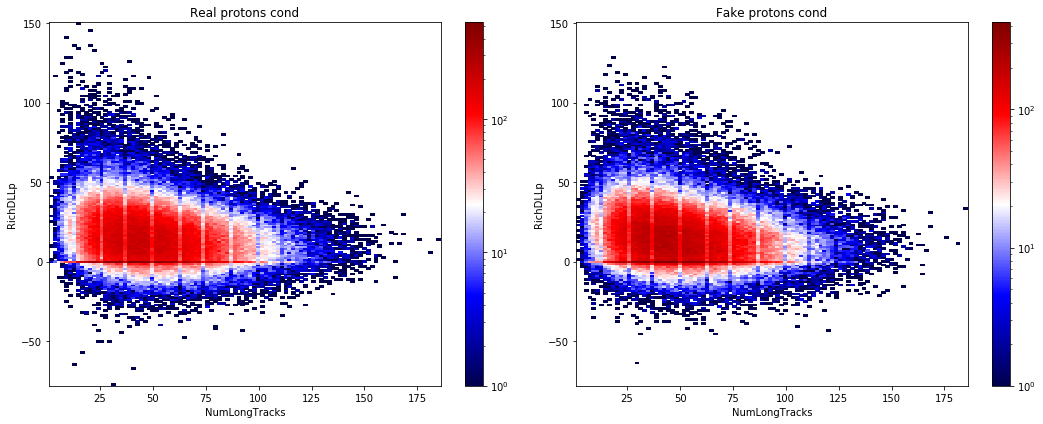

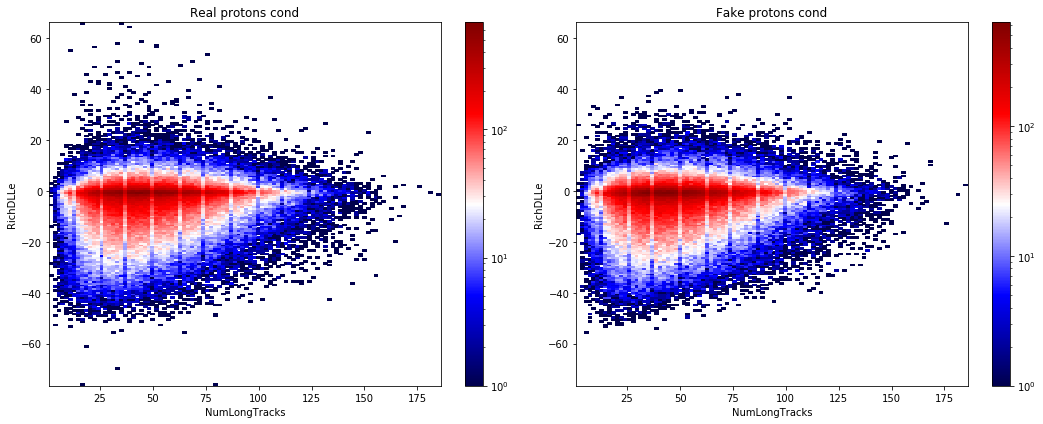

In [70]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(XY_test_back, Y_pred_proton_cond, 'protons cond', x_name, y_name)